In [1]:
import pandas as pd
import numpy as np
import pymannkendall as mk
import os
from collections import defaultdict, OrderedDict
from typing import Dict, List, Tuple
import glob

# ======================
# DATA PROCESSING MODULE
# ======================

def combine_fluxnet_datasets(ds1_path: str, ds2_path: str, output_path: str) -> None:
    """
    Combine two FLUXNET datasets, prioritizing non-missing values (-9999) from ds2
    
    Args:
        ds1_path: Path to first dataset (typically older data)
        ds2_path: Path to second dataset (typically newer data)
        output_path: Path to save combined dataset
    """
    # Core variables to include (TIMESTAMP must be first)
    core_vars = [
        'TIMESTAMP',
        # Base variables
        'LE_F_MDS', 'H_F_MDS', 'G_F_MDS', 'NETRAD', 'TA_F',
        'TS_F_MDS_1', 'VPD_F', 'P_F', 'SWC_F_MDS_1', 'GPP_NT_VUT_MEAN',
        # Corrected versions
        'LE_CORR', 'H_CORR',
        # Quality control flags
        'LE_F_MDS_QC', 'H_F_MDS_QC', 'G_F_MDS_QC', 'TA_F_QC',
        'TS_F_MDS_1_QC', 'VPD_F_QC', 'P_F_QC', 'SWC_F_MDS_1_QC',
    ]

    # Load datasets with only needed columns
    ds1 = pd.read_csv(ds1_path, usecols=lambda x: x in core_vars)
    ds2 = pd.read_csv(ds2_path, usecols=lambda x: x in core_vars)

    # Convert TIMESTAMP to datetime
    for df in [ds1, ds2]:
        df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], format='%Y%m')

    # Process overlapping dates - prioritize non -9999 values from ds2
    overlap_dates = set(ds1['TIMESTAMP']).intersection(set(ds2['TIMESTAMP']))
    
    for date in overlap_dates:
        for var in core_vars[1:]:  # Skip TIMESTAMP
            if var in ds1.columns and var in ds2.columns:
                val1 = ds1.loc[ds1['TIMESTAMP'] == date, var].values[0]
                val2 = ds2.loc[ds2['TIMESTAMP'] == date, var].values[0]
                
                if val2 != -9999:  # Prefer ds2 value if not missing
                    ds1.loc[ds1['TIMESTAMP'] == date, var] = val2

    # Remove overlapping dates from ds2 and concatenate
    ds2 = ds2[~ds2['TIMESTAMP'].isin(overlap_dates)]
    combined_df = pd.concat([ds1, ds2]).sort_values('TIMESTAMP')
    
    # Convert TIMESTAMP back to original format and save
    combined_df['TIMESTAMP'] = combined_df['TIMESTAMP'].dt.strftime('%Y%m')
    combined_df.to_csv(output_path, index=False)
    
    print(f"Combined data saved to {output_path}")
    print(f"Time coverage: {combined_df['TIMESTAMP'].min()} to {combined_df['TIMESTAMP'].max()}")

# ======================
# COMPLETENESS ANALYSIS
# ======================

def validate_variable(df: pd.DataFrame, var: str) -> List[int]:
    """
    Identify complete years for a variable based on QC flags
    
    Args:
        df: Input DataFrame with data
        var: Variable name to validate
    
    Returns:
        List of years with complete data (12 months)
    """
    qc_col = var + '_QC' if var + '_QC' in df.columns else None
    
    if qc_col:
        valid_mask = (df[qc_col] > 0.8) & (df[var] != -9999.0)
    else:
        valid_mask = (df[var] != -9999.0)
    
    valid_data = df[valid_mask].copy()
    valid_year_counts = valid_data['Year'].value_counts()
    return valid_year_counts[valid_year_counts == 12].index.tolist()

def get_complete_years(df: pd.DataFrame, variables: List[str]) -> List[int]:
    """
    Find years where all specified variables have complete data
    
    Args:
        df: Input DataFrame with data
        variables: List of variables to check
    
    Returns:
        Sorted list of years with complete data for all variables
    """
    common_years = set(df['Year'].unique())
    for var in variables:
        valid_years = validate_variable(df, var)
        common_years.intersection_update(valid_years)
    return sorted(common_years)

def identify_problematic_variable(df: pd.DataFrame, variables: List[str]) -> str:
    """
    Find which variable reduces completeness the most
    
    Args:
        df: Input DataFrame with data
        variables: List of variables to evaluate
    
    Returns:
        Name of the most problematic variable
    """
    base_years = get_complete_years(df, variables)
    var_impact = {}
    
    for var in variables:
        test_vars = [v for v in variables if v != var]
        test_years = get_complete_years(df, test_vars)
        var_impact[var] = len(test_years) - len(base_years)
    
    return max(var_impact.items(), key=lambda x: x[1])[0]


def save_variable_year_availability(df: pd.DataFrame, variables: List[str], output_file: str) -> None:
    """
    Save availability of each variable (years with valid data after QC and missing check)

    Args:
        df: DataFrame with Year, QC, and variable columns
        variables: List of variables to check
        output_file: Path to save CSV
    """
    availability_records = []

    for var in variables:
        valid_years = validate_variable(df, var)
        availability_records.append({
            "Variable": var,
            "Valid_Years": ", ".join(map(str, sorted(valid_years))),
            "Count_Valid_Years": len(valid_years)
        })

    availability_df = pd.DataFrame(availability_records)
    availability_df.to_csv(output_file, index=False)
    print(f"Variable availability saved to {output_file}")


def save_recursive_year_availability(df: pd.DataFrame, variables: List[str], output_file: str) -> None:
    """
    Save recursive completeness progression:
    Start with all variables, list available years,
    then remove the most problematic variable and repeat.

    Args:
        df: DataFrame with Year and variables
        variables: List of variables to analyze
        output_file: Path to save CSV
    """
    progression_records = []
    current_vars = variables.copy()

    while len(current_vars) > 1:
        complete_years = get_complete_years(df, current_vars)
        progression_records.append({
            "Step": len(progression_records) + 1,
            "Variables_Included": ", ".join(current_vars),
            "Count_Variables": len(current_vars),
            "Years_Available": ", ".join(map(str, complete_years)),
            "Count_Years": len(complete_years)
        })

        if len(current_vars) > 2:
            problematic_var = identify_problematic_variable(df, current_vars)
            current_vars.remove(problematic_var)
        else:
            break

    progression_df = pd.DataFrame(progression_records)
    progression_df.to_csv(output_file, index=False)
    print(f"Recursive year availability progression saved to {output_file}")


# ======================
# YEARLY ANALYSIS
# ======================

def calculate_yearly_means(df: pd.DataFrame, variables: List[str], years: List[int]) -> pd.DataFrame:
    """
    Calculate yearly means for complete years only
    
    Args:
        df: Input DataFrame with data
        variables: Variables to calculate means for
        years: Years to include
    
    Returns:
        DataFrame with yearly means
    """
    if not years:
        return pd.DataFrame()
    
    complete_data = df[df['Year'].isin(years)]
    return complete_data.groupby('Year')[variables].mean()

def generate_recursive_means(df: pd.DataFrame, variables: List[str]) -> Dict[str, pd.DataFrame]:
    """
    Generate yearly means by recursively removing problematic variables
    
    Args:
        df: Input DataFrame with data
        variables: List of variables to analyze
    
    Returns:
        Dictionary of DataFrames with different variable combinations
    """
    results = OrderedDict()
    current_vars = variables.copy()
    
    # Initial run with all variables
    complete_years = get_complete_years(df, current_vars)
    yearly_means = calculate_yearly_means(df, current_vars, complete_years)
    results["All Variables"] = yearly_means
    
    # Recursively remove most problematic variable
    while len(current_vars) > 2:
        problematic_var = identify_problematic_variable(df, current_vars)
        current_vars.remove(problematic_var)
        
        complete_years = get_complete_years(df, current_vars)
        yearly_means = calculate_yearly_means(df, current_vars, complete_years)
        results[f"Excluded {problematic_var}"] = yearly_means
    
    return results

# ======================
# SEASONAL ANALYSIS
# ======================

def get_season_months(season: str) -> List[int]:
    """Return months for each season (with DJF year adjustment)"""
    return {
        'DJF': [12, 1, 2],  # December, January, February
        'MAM': [3, 4, 5],   # March, April, May
        'JJA': [6, 7, 8],   # June, July, August
        'SON': [9, 10, 11]  # September, October, November
    }[season]

def get_complete_seasons(df: pd.DataFrame, variables: List[str], season: str) -> List[int]:
    """
    Get seasons with complete data for all variables
    
    Args:
        df: Input DataFrame
        variables: Variables to check
        season: Season code (DJF, MAM, JJA, SON)
    
    Returns:
        List of complete season years
    """
    season_months = get_season_months(season)
    df_season = df[df['Month'].isin(season_months)].copy()
    
    # Adjust year for winter season (DJF)
    if season == 'DJF':
        df_season['Season_Year'] = df_season['Year']
        df_season.loc[df_season['Month'] == 12, 'Season_Year'] += 1
    else:
        df_season['Season_Year'] = df_season['Year']
    
    # Find seasons with all months present
    month_counts = df_season.groupby(['Season_Year'])['Month'].nunique()
    complete_seasons = month_counts[month_counts == 3].index.tolist()
    
    # Check variable completeness
    valid_seasons = []
    for season_year in complete_seasons:
        season_data = df_season[df_season['Season_Year'] == season_year]
        valid = True
        for var in variables:
            if var+'_QC' in df.columns:
                var_data = season_data[(season_data[var+'_QC'] > 0.8) & (season_data[var] != -9999.0)]
            else:
                var_data = season_data[season_data[var] != -9999.0]
            if len(var_data) < 3:  # Not all months valid
                valid = False
                break
        if valid:
            valid_seasons.append(season_year)
    
    return sorted(valid_seasons)

def generate_recursive_seasonal_means(df: pd.DataFrame, variables: List[str], season: str) -> Dict[str, pd.DataFrame]:
    """
    Generate seasonal means by recursively removing problematic variables
    
    Args:
        df: Input DataFrame
        variables: Variables to analyze
        season: Season code (DJF, MAM, JJA, SON)
    
    Returns:
        Dictionary of DataFrames with different variable combinations
    """
    results = OrderedDict()
    current_vars = variables.copy()
    
    # Initial run with all variables
    complete_seasons = get_complete_seasons(df, current_vars, season)
    seasonal_means = calculate_seasonal_means(df, current_vars, season, complete_seasons)
    results["All Variables"] = seasonal_means
    
    # Recursively remove problematic variables
    while len(current_vars) > 2:
        problematic_var = identify_problematic_variable_season(df, current_vars, season)
        if not problematic_var:
            break
            
        current_vars.remove(problematic_var)
        complete_seasons = get_complete_seasons(df, current_vars, season)
        seasonal_means = calculate_seasonal_means(df, current_vars, season, complete_seasons)
        results[f"Excluded {problematic_var}"] = seasonal_means
    
    return results

def calculate_seasonal_means(df: pd.DataFrame, variables: List[str], season: str, season_years: List[int]) -> pd.DataFrame:
    """
    Calculate seasonal means for complete seasons
    
    Args:
        df: Input DataFrame
        variables: Variables to calculate means for
        season: Season code (DJF, MAM, JJA, SON)
        season_years: List of years with complete seasonal data
    
    Returns:
        DataFrame with seasonal means
    """
    if not season_years:
        return pd.DataFrame()
    
    season_months = get_season_months(season)
    df_season = df[df['Month'].isin(season_months)].copy()
    
    # Adjust year for winter season (DJF)
    if season == 'DJF':
        df_season['Season_Year'] = df_season['Year']
        df_season.loc[df_season['Month'] == 12, 'Season_Year'] += 1
    else:
        df_season['Season_Year'] = df_season['Year']
    
    # Filter for complete seasons
    df_season = df_season[df_season['Season_Year'].isin(season_years)]
    
    # Calculate seasonal means
    seasonal_means = df_season.groupby('Season_Year')[variables].mean()
    seasonal_means['Season'] = season
    return seasonal_means.reset_index().set_index(['Season_Year', 'Season'])

def identify_problematic_variable_season(df: pd.DataFrame, variables: List[str], season: str) -> str:
    """
    Find which variable reduces seasonal completeness the most
    
    Args:
        df: Input DataFrame
        variables: Variables to evaluate
        season: Season code (DJF, MAM, JJA, SON)
    
    Returns:
        Name of the most problematic variable
    """
    base_seasons = get_complete_seasons(df, variables, season)
    var_impact = {}
    
    for var in variables:
        test_vars = [v for v in variables if v != var]
        test_seasons = get_complete_seasons(df, test_vars, season)
        var_impact[var] = len(test_seasons) - len(base_seasons)
    
    return max(var_impact.items(), key=lambda x: x[1])[0] if var_impact else None

# ======================
# TREND ANALYSIS
# ======================

def calculate_trend_stats(series: pd.Series) -> Dict[str, float]:
    """
    Calculate Mann-Kendall trend statistics
    
    Args:
        series: Time series data
    
    Returns:
        Dictionary with slope, p-value, and period info
    """
    if series.notna().sum() < 10:
        return None
    
    start_year = int(series.index.min())
    end_year = int(series.index.max())
    full_index = np.arange(start_year, end_year + 1, 1)
    series = series.reindex(full_index)
    
    try:
        result = mk.original_test(series.values)
        return {
            'slope': result.slope,
            'p_value': result.p,
            'period': f"{start_year}-{end_year} ({series.notna().sum()})"
        }
    except Exception:
        return None

def build_trend_tables(sheets: Dict[str, pd.DataFrame]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Build p-value and slope tables from analysis results
    
    Args:
        sheets: Dictionary of DataFrames from analysis
    
    Returns:
        Tuple of (p-value table, slope table)
    """
    year_groups = defaultdict(list)
    
    # Sort sheets by number of variables (ascending)
    sorted_sheets = sorted(sheets.items(),
                         key=lambda x: len([col for col in x[1].columns if col not in ['Season_Year', 'Season']]),
                         reverse=False)

    for sheet_name, data in sorted_sheets:
        if 'Season_Year' in data.columns:
            data = data.set_index('Season_Year')
        elif 'Year' in data.columns:
            data = data.set_index('Year')

        vars_included = [col for col in data.columns if col not in ['Season', 'Year']]
        if len(vars_included) < 2:
            continue

        # Calculate stats for all variables
        stats_dict = {}
        period = None
        for var in vars_included:
            stats = calculate_trend_stats(data[var].dropna())
            if stats:
                stats_dict[var] = {
                    'p_value': stats['p_value'],
                    'slope': stats['slope']
                }
                period = stats['period']
        
        if stats_dict:
            year_groups[period].append({
                'vars': vars_included,
                'stats': stats_dict
            })
    
    # Build final tables
    p_table, slope_table = [], []
    
    for period, combinations in year_groups.items():
        max_vars = max(len(c['vars']) for c in combinations)
        best_comb = next(c for c in combinations if len(c['vars']) == max_vars)
        
        p_row = {'Years': period, 'Variable Combination': ', '.join(best_comb['vars'])}
        s_row = {'Years': period, 'Variable Combination': ', '.join(best_comb['vars'])}
        
        for var in best_comb['vars']:
            p_row[var] = best_comb['stats'][var]['p_value']
            s_row[var] = best_comb['stats'][var]['slope']
        
        p_table.append(p_row)
        slope_table.append(s_row)
    
    return pd.DataFrame(p_table), pd.DataFrame(slope_table)

# ======================
# MAIN EXECUTION
# ======================

#def run_full_analysis(station_code: str = "FI-Hyy"):
    """Run complete analysis pipeline with outputs in station-specific folder"""

    # Build folder path automatically from station code
    station_folder_name = station_code.split("-")[1]  # e.g., "FI-Bra" -> "Bra"
    base_dir = os.path.join(r"C:\Deepak\stations\MM\Final", station_folder_name)

    # Make sure output folder exists
    os.makedirs(base_dir, exist_ok=True)

    # File paths for inputs
    ds1_path = os.path.join(base_dir, f'FLX_{station_code}_FLUXNET2015_FULLSET_MM_*-2020_beta-3.csv')
    ds2_path = os.path.join(base_dir, f'ICOSETC_{station_code}_FLUXNET_MM_L2.csv')

    # File path for combined dataset
    combined_path = os.path.join(base_dir, f"{station_code}_Fluxnet_Combined.csv")

    # Combine datasets
    combine_fluxnet_datasets(ds1_path, ds2_path, combined_path)

    # Load and prepare data
    df = pd.read_csv(combined_path)
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], format='%Y%m')
    df['Year'] = df['TIMESTAMP'].dt.year
    df['Month'] = df['TIMESTAMP'].dt.month

    # Get variable columns (excluding QC and metadata)
    variables = [col for col in df.columns
                 if not col.endswith('_QC')
                 and col not in ['TIMESTAMP', 'Year', 'Month']]

    # Save variable availability reports
    save_variable_year_availability(df, variables, os.path.join(base_dir, f"{station_code}_variable_year_availability.csv"))
    save_recursive_year_availability(df, variables, os.path.join(base_dir, f"{station_code}_recursive_year_availability.csv"))

    # Yearly analysis
    yearly_results = generate_recursive_means(df, variables)
    yearly_file = os.path.join(base_dir, f'strict_recursive_yearly_means_{station_code}.xlsx')
    with pd.ExcelWriter(yearly_file) as writer:
        for sheet_name, data in yearly_results.items():
            if not data.empty:
                data.to_excel(writer, sheet_name=sheet_name[:31])

    # Seasonal analysis
    seasons = ['DJF', 'MAM', 'JJA', 'SON']
    for season in seasons:
        seasonal_results = generate_recursive_seasonal_means(df, variables, season)
        seasonal_file = os.path.join(base_dir, f"strict_recursive_seasonal_means_{station_code}_{season}.xlsx")
        with pd.ExcelWriter(seasonal_file) as writer:
            for sheet_name, data in seasonal_results.items():
                if not data.empty:
                    data.reset_index().to_excel(writer, sheet_name=sheet_name[:31], index=False)

    # Yearly trend analysis
    yearly_sheets = pd.read_excel(yearly_file, sheet_name=None)
    p_table, slope_table = build_trend_tables(yearly_sheets)
    with pd.ExcelWriter(os.path.join(base_dir, f'progressive_trend_tables_{station_code}_yearly.xlsx')) as writer:
        p_table.to_excel(writer, sheet_name='P-values', index=False)
        slope_table.to_excel(writer, sheet_name='Slopes', index=False)

    # Seasonal trend analysis
    for season in seasons:
        seasonal_file = os.path.join(base_dir, f"strict_recursive_seasonal_means_{station_code}_{season}.xlsx")
        try:
            seasonal_sheets = pd.read_excel(seasonal_file, sheet_name=None)
            p_table, slope_table = build_trend_tables(seasonal_sheets)
            with pd.ExcelWriter(os.path.join(base_dir, f'progressive_trend_tables_{station_code}_{season}.xlsx')) as writer:
                p_table.to_excel(writer, sheet_name='P-values', index=False)
                slope_table.to_excel(writer, sheet_name='Slopes', index=False)
        except FileNotFoundError:
            print(f"Warning: No data file found for {season} season")

def run_full_analysis(station_code: str):
    """Run complete analysis pipeline with outputs in station-specific folder"""
    # Build folder path automatically from station code
    station_folder_name = station_code.split("-")[1]  # e.g., "FI-Bra" -> "Bra"
    base_dir = os.path.join(r"C:\Deepak\stations\MM\Final", station_folder_name)
    os.makedirs(base_dir, exist_ok=True)

    # Find FLX and ICOSETC files for the station
    flx_pattern = f"FLX_{station_code}_FLUXNET2015_FULLSET_MM_*_beta-3.csv"
    icosetc_pattern = f"ICOSETC_{station_code}_FLUXNET_MM_L2.csv"

    # Search for files in the parent directory
    flx_files = glob.glob(os.path.join(r"C:\Deepak\stations\MM", flx_pattern))
    icosetc_files = glob.glob(os.path.join(r"C:\Deepak\stations\MM", icosetc_pattern))

    if not flx_files or not icosetc_files:
        print(f"Files not found for {station_code}. Skipping...")
        return

    # Use the first match (assuming there's only one)
    ds1_path = flx_files[0]
    ds2_path = icosetc_files[0]

    # File path for combined dataset
    combined_path = os.path.join(base_dir, f"{station_code}_Fluxnet_Combined.csv")

    # Combine datasets
    combine_fluxnet_datasets(ds1_path, ds2_path, combined_path)

    # Load and prepare data
    df = pd.read_csv(combined_path)
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], format='%Y%m')
    df['Year'] = df['TIMESTAMP'].dt.year
    df['Month'] = df['TIMESTAMP'].dt.month

    # Get variable columns (excluding QC and metadata)
    variables = [col for col in df.columns
                 if not col.endswith('_QC')
                 and col not in ['TIMESTAMP', 'Year', 'Month']]

    # Save variable availability reports
    save_variable_year_availability(df, variables, os.path.join(base_dir, f"{station_code}_variable_year_availability.csv"))
    save_recursive_year_availability(df, variables, os.path.join(base_dir, f"{station_code}_recursive_year_availability.csv"))

    # Yearly analysis
    yearly_results = generate_recursive_means(df, variables)
    yearly_file = os.path.join(base_dir, f'strict_recursive_yearly_means_{station_code}.xlsx')
    if any(not data.empty for data in yearly_results.values()):

       with pd.ExcelWriter(yearly_file) as writer:
        for sheet_name, data in yearly_results.items():
            if not data.empty:
                data.to_excel(writer, sheet_name=sheet_name[:31])

    else:
     print(f"No data to save for yearly means for {station_code}. Skipping Excel file creation.")

    # Seasonal analysis
    seasons = ['DJF', 'MAM', 'JJA', 'SON']
    for season in seasons:
        seasonal_results = generate_recursive_seasonal_means(df, variables, season)
        seasonal_file = os.path.join(base_dir, f"strict_recursive_seasonal_means_{station_code}_{season}.xlsx")
        if any(not data.empty for data in seasonal_results.values()):

         with pd.ExcelWriter(seasonal_file) as writer:
            for sheet_name, data in seasonal_results.items():
                if not data.empty:
                    data.reset_index().to_excel(writer, sheet_name=sheet_name[:31], index=False)
                else:
                 print(f"No data to save for seasonal means for {station_code} ({season}). Skipping Excel file creation.")
    # Yearly trend analysis
    yearly_sheets = pd.read_excel(yearly_file, sheet_name=None)
    p_table, slope_table = build_trend_tables(yearly_sheets)
    with pd.ExcelWriter(os.path.join(base_dir, f'progressive_trend_tables_{station_code}_yearly.xlsx')) as writer:
        p_table.to_excel(writer, sheet_name='P-values', index=False)
        slope_table.to_excel(writer, sheet_name='Slopes', index=False)

    # Seasonal trend analysis
    for season in seasons:
        seasonal_file = os.path.join(base_dir, f"strict_recursive_seasonal_means_{station_code}_{season}.xlsx")
        try:
            seasonal_sheets = pd.read_excel(seasonal_file, sheet_name=None)
            p_table, slope_table = build_trend_tables(seasonal_sheets)
            with pd.ExcelWriter(os.path.join(base_dir, f'progressive_trend_tables_{station_code}_{season}.xlsx')) as writer:
                p_table.to_excel(writer, sheet_name='P-values', index=False)
                slope_table.to_excel(writer, sheet_name='Slopes', index=False)
        except FileNotFoundError:
            print(f"Warning: No data file found for {season} season")

#if __name__ == "__main__":
    #run_full_analysis("BE-Bra")
   # run_full_analysis("FI-Hyy")
    #run_full_analysis("DE-Tha")


In [ ]:
import numpy as np
import pymannkendall as mk


data = np.array([
    3.453767083, 3.77697995, 4.0161395, 4.404460742, 4.260551275, 4.174563833,
    4.48972, 3.382869083, 3.7710225, 3.832464992, 3.558067917, 2.434592333,
    4.369564583, 4.369519667, 3.97802885, 4.14561475, 3.896000667, 3.922338,
    4.462562417, 4.30264775, 4.69167225, 4.60689075, 3.749627583, 4.18201275,
    2.349085, 4.921183667, 4.48183975, 4.792183417
])

# Perform Mann-Kendall test
result = mk.original_test(data)


result.p


np.float64(0.050477473834512177)

In [ ]:

data2 = np.array([
    33.071961, 27.47026983, 24.3015225, 27.10003867, 26.201129, 20.44217867,
    21.03798275, 41.29880267, 28.33163833, 29.40995273, 28.45507667, 28.644646,
    26.62623083, 27.03697333, 26.99581083, 34.16811217, 31.13212267, 24.44250333,
    26.21327083, 32.5066, 27.1318475, 27.85178525, 44.43696167, 34.50343833,
    -14.1410875, 34.15065167, 46.66989083, 36.96086583
])


result1 = mk.original_test(data2)

# Extract p-value
result1.p



np.float64(0.050477473834512177)

In [12]:
import os

# Base directory for outputs
base_output_dir = r"C:\Deepak\stations\MM\Final"

# List of stations to process
stations_to_process = [
    'BE-Dor', 'BE-Lon', 'BE-Maa', 'BE-Vie', 'CH-Dav', 'CZ-BK1', 'CZ-Lnz', 'CZ-wet',
    'DE-Geb', 'DE-Gri', 'DE-HoH', 'DE-Hzd', 'DE-Kli', 'DE-RuR', 'DE-RuS', 'DE-RuW',
    'DK-Sor', 'FI-Ken', 'FI-Let', 'FI-Sii', 'FI-Var', 'FR-Aur', 'FR-Bil', 'FR-FBn',
    'FR-Fon', 'FR-Gri', 'FR-Hes', 'FR-Tou', 'GF-Guy', 'GL-Dsk', 'IT-BCi', 'IT-BFt',
    'IT-Cp2', 'IT-Lsn', 'IT-MBo', 'IT-Ren', 'IT-SR2', 'IT-Tor', 'SE-Deg', 'SE-Htm',
    'SE-Nor', 'SE-Svb'
]

# Loop through each station and run the analysis if the folder does not exist
for station_code in stations_to_process:
    station_folder_name = station_code.split("-")[1]  # e.g., "FI-Bra" -> "Bra"
    station_output_dir = os.path.join(base_output_dir, station_folder_name)

    # Check if the folder already exists
    if not os.path.exists(station_output_dir):
        print(f"Processing {station_code}...")
        # Run the analysis
        run_full_analysis(station_code)
    else:
        print(f"Skipping {station_code}: Folder already exists.")


Skipping BE-Dor: Folder already exists.
Skipping BE-Lon: Folder already exists.
Skipping BE-Maa: Folder already exists.
Skipping BE-Vie: Folder already exists.
Skipping CH-Dav: Folder already exists.
Skipping CZ-BK1: Folder already exists.
Skipping CZ-Lnz: Folder already exists.
Skipping CZ-wet: Folder already exists.
Skipping DE-Geb: Folder already exists.
Skipping DE-Gri: Folder already exists.
Skipping DE-HoH: Folder already exists.
Skipping DE-Hzd: Folder already exists.
Skipping DE-Kli: Folder already exists.
Skipping DE-RuR: Folder already exists.
Skipping DE-RuS: Folder already exists.
Skipping DE-RuW: Folder already exists.
Skipping DK-Sor: Folder already exists.
Skipping FI-Ken: Folder already exists.
Skipping FI-Let: Folder already exists.
Skipping FI-Sii: Folder already exists.
Skipping FI-Var: Folder already exists.
Skipping FR-Aur: Folder already exists.
Skipping FR-Bil: Folder already exists.
Skipping FR-FBn: Folder already exists.
Skipping FR-Fon: Folder already exists.


C:\Users\chinthap\AppData\Local\Temp\ipykernel_5344\1237575332.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '28.206' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ds1.loc[ds1['TIMESTAMP'] == date, var] = val2
C:\Users\chinthap\AppData\Local\Temp\ipykernel_5344\1237575332.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-4.08724' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ds1.loc[ds1['TIMESTAMP'] == date, var] = val2
C:\Users\chinthap\AppData\Local\Temp\ipykernel_5344\1237575332.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.148522' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ds1.loc[ds1['TIM

Combined data saved to C:\Deepak\stations\MM\Final\Dsk\GL-Dsk_Fluxnet_Combined.csv
Time coverage: 202001 to 202412
Variable availability saved to C:\Deepak\stations\MM\Final\Dsk\GL-Dsk_variable_year_availability.csv
Recursive year availability progression saved to C:\Deepak\stations\MM\Final\Dsk\GL-Dsk_recursive_year_availability.csv
No data to save for seasonal means for GL-Dsk (DJF). Skipping Excel file creation.
No data to save for seasonal means for GL-Dsk (DJF). Skipping Excel file creation.
No data to save for seasonal means for GL-Dsk (DJF). Skipping Excel file creation.
No data to save for seasonal means for GL-Dsk (DJF). Skipping Excel file creation.
No data to save for seasonal means for GL-Dsk (DJF). Skipping Excel file creation.
No data to save for seasonal means for GL-Dsk (DJF). Skipping Excel file creation.
No data to save for seasonal means for GL-Dsk (DJF). Skipping Excel file creation.
No data to save for seasonal means for GL-Dsk (DJF). Skipping Excel file creation.


In [ ]:
 'BE-Dor', 'BE-Lon', 'BE-Maa', 'BE-Vie', 'CH-Dav', 'CZ-BK1', 'CZ-Lnz', 'CZ-wet',
    'DE-Geb', 'DE-Gri', 'DE-HoH', 'DE-Hzd', 'DE-Kli', 'DE-RuR', 'DE-RuS', 'DE-RuW',
    'DK-Sor', 'FI-Ken', 'FI-Let', 'FI-Sii', 'FI-Var', 'FR-Aur', 'FR-Bil', 'FR-FBn',
    'FR-Fon', 'FR-Gri', 'FR-Hes', 'FR-Tou', 'GF-Guy', 'GL-Dsk', 'IT-BCi', 'IT-BFt',
    'IT-Cp2', 'IT-Lsn', 'IT-MBo', 'IT-Ren', 'IT-SR2', 'IT-Tor', 'SE-Deg', 'SE-Htm',
    'SE-Nor', 'SE-Svb',"BE-Bra","FI-Hyy","DE-Tha",
   

In [3]:
import os

# Base directory for outputs
base_output_dir = r"C:\Deepak\stations\MM\Final"

# List of stations to process
stations_to_process = [
    'CH-BaK'
]

# Loop through each station and run the analysis if the folder does not exist
for station_code in stations_to_process:
    station_folder_name = station_code.split("-")[1]  # e.g., "FI-Bra" -> "Bra"
    station_output_dir = os.path.join(base_output_dir, station_folder_name)

    # Check if the folder already exists
    if not os.path.exists(station_output_dir):
        print(f"Processing {station_code}...")
        # Run the analysis
        run_full_analysis(station_code)
    else:
        print(f"Skipping {station_code}: Folder already exists.")


Processing CH-BaK...
Files not found for CH-BaK. Skipping...


In [14]:
import pandas as pd
import numpy as np
import pymannkendall as mk
import os
from collections import defaultdict, OrderedDict
from typing import Dict, List, Tuple
import glob

# ======================
# DATA PROCESSING MODULE
# ======================

def combine_fluxnet_datasets(ds1_path: str, ds2_path: str, output_path: str) -> None:
    """
    Combine two FLUXNET datasets, prioritizing non-missing values (-9999) from ds2
    Also handles cases where only one dataset is available
    """
    # Core variables to include (TIMESTAMP must be first)
    core_vars = [
        'TIMESTAMP',
        # Base variables
        'LE_F_MDS', 'H_F_MDS', 'G_F_MDS', 'NETRAD', 'TA_F',
        'TS_F_MDS_1', 'VPD_F', 'P_F', 'SWC_F_MDS_1', 'GPP_DT_VUT_MEAN',
        # Corrected versions
        'LE_CORR', 'H_CORR',
        # Quality control flags
        'LE_F_MDS_QC', 'H_F_MDS_QC', 'G_F_MDS_QC', 'TA_F_QC',
        'TS_F_MDS_1_QC', 'VPD_F_QC', 'P_F_QC', 'SWC_F_MDS_1_QC',
    ]

    # Handle cases where only one dataset is provided
    if ds1_path is None and ds2_path is None:
        raise ValueError("At least one dataset path must be provided")
    
    if ds1_path is None:
        # Only ds2 available - load only core variables
        ds2 = pd.read_csv(ds2_path, usecols=lambda x: x in core_vars)
        ds2['TIMESTAMP'] = pd.to_datetime(ds2['TIMESTAMP'], format='%Y%m')
        ds2['TIMESTAMP'] = ds2['TIMESTAMP'].dt.strftime('%Y%m')
        ds2.to_csv(output_path, index=False)
        print(f"Single dataset saved to {output_path}")
        print(f"Time coverage: {ds2['TIMESTAMP'].min()} to {ds2['TIMESTAMP'].max()}")
        return
    
    if ds2_path is None:
        # Only ds1 available - load only core variables
        ds1 = pd.read_csv(ds1_path, usecols=lambda x: x in core_vars)
        ds1['TIMESTAMP'] = pd.to_datetime(ds1['TIMESTAMP'], format='%Y%m')
        ds1['TIMESTAMP'] = ds1['TIMESTAMP'].dt.strftime('%Y%m')
        ds1.to_csv(output_path, index=False)
        print(f"Single dataset saved to {output_path}")
        print(f"Time coverage: {ds1['TIMESTAMP'].min()} to {ds1['TIMESTAMP'].max()}")
        return
    # Original combining logic for two datasets...
    # Load datasets with only needed columns
    
    # Load datasets with only needed columns
    ds1 = pd.read_csv(ds1_path, usecols=lambda x: x in core_vars)
    ds2 = pd.read_csv(ds2_path, usecols=lambda x: x in core_vars)

    # Convert TIMESTAMP to datetime
    for df in [ds1, ds2]:
        df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], format='%Y%m')

    # Process overlapping dates - prioritize non -9999 values from ds2
    overlap_dates = set(ds1['TIMESTAMP']).intersection(set(ds2['TIMESTAMP']))
    
    for date in overlap_dates:
        for var in core_vars[1:]:  # Skip TIMESTAMP
            if var in ds1.columns and var in ds2.columns:
                val1 = ds1.loc[ds1['TIMESTAMP'] == date, var].values[0]
                val2 = ds2.loc[ds2['TIMESTAMP'] == date, var].values[0]
                
                if val2 != -9999:  # Prefer ds2 value if not missing
                    ds1.loc[ds1['TIMESTAMP'] == date, var] = val2

    # Remove overlapping dates from ds2 and concatenate
    ds2 = ds2[~ds2['TIMESTAMP'].isin(overlap_dates)]
    combined_df = pd.concat([ds1, ds2]).sort_values('TIMESTAMP')
    
    # Convert TIMESTAMP back to original format and save
    combined_df['TIMESTAMP'] = combined_df['TIMESTAMP'].dt.strftime('%Y%m')
    combined_df.to_csv(output_path, index=False)
    
    print(f"Combined data saved to {output_path}")
    print(f"Time coverage: {combined_df['TIMESTAMP'].min()} to {combined_df['TIMESTAMP'].max()}")

# ======================
# COMPLETENESS ANALYSIS
# ======================

def validate_variable(df: pd.DataFrame, var: str) -> List[int]:
    """
    Identify complete years for a variable based on QC flags
    
    Args:
        df: Input DataFrame with data
        var: Variable name to validate
    
    Returns:
        List of years with complete data (12 months)
    """
    qc_col = var + '_QC' if var + '_QC' in df.columns else None
    
    if qc_col:
        valid_mask = (df[qc_col] > 0.8) & (df[var] != -9999.0)
    else:
        valid_mask = (df[var] != -9999.0)
    
    valid_data = df[valid_mask].copy()
    valid_year_counts = valid_data['Year'].value_counts()
    return valid_year_counts[valid_year_counts == 12].index.tolist()

def get_complete_years(df: pd.DataFrame, variables: List[str]) -> List[int]:
    """
    Find years where all specified variables have complete data
    
    Args:
        df: Input DataFrame with data
        variables: List of variables to check
    
    Returns:
        Sorted list of years with complete data for all variables
    """
    common_years = set(df['Year'].unique())
    for var in variables:
        valid_years = validate_variable(df, var)
        common_years.intersection_update(valid_years)
    return sorted(common_years)

def identify_problematic_variable(df: pd.DataFrame, variables: List[str]) -> str:
    """
    Find which variable reduces completeness the most
    
    Args:
        df: Input DataFrame with data
        variables: List of variables to evaluate
    
    Returns:
        Name of the most problematic variable
    """
    base_years = get_complete_years(df, variables)
    var_impact = {}
    
    for var in variables:
        test_vars = [v for v in variables if v != var]
        test_years = get_complete_years(df, test_vars)
        var_impact[var] = len(test_years) - len(base_years)
    
    return max(var_impact.items(), key=lambda x: x[1])[0]


def save_variable_year_availability(df: pd.DataFrame, variables: List[str], output_file: str) -> None:
    """
    Save availability of each variable (years with valid data after QC and missing check)

    Args:
        df: DataFrame with Year, QC, and variable columns
        variables: List of variables to check
        output_file: Path to save CSV
    """
    availability_records = []

    for var in variables:
        valid_years = validate_variable(df, var)
        availability_records.append({
            "Variable": var,
            "Valid_Years": ", ".join(map(str, sorted(valid_years))),
            "Count_Valid_Years": len(valid_years)
        })

    availability_df = pd.DataFrame(availability_records)
    availability_df.to_csv(output_file, index=False)
    print(f"Variable availability saved to {output_file}")


def save_recursive_year_availability(df: pd.DataFrame, variables: List[str], output_file: str) -> None:
    """
    Save recursive completeness progression:
    Start with all variables, list available years,
    then remove the most problematic variable and repeat.

    Args:
        df: DataFrame with Year and variables
        variables: List of variables to analyze
        output_file: Path to save CSV
    """
    progression_records = []
    current_vars = variables.copy()

    while len(current_vars) > 1:
        complete_years = get_complete_years(df, current_vars)
        progression_records.append({
            "Step": len(progression_records) + 1,
            "Variables_Included": ", ".join(current_vars),
            "Count_Variables": len(current_vars),
            "Years_Available": ", ".join(map(str, complete_years)),
            "Count_Years": len(complete_years)
        })

        if len(current_vars) > 2:
            problematic_var = identify_problematic_variable(df, current_vars)
            current_vars.remove(problematic_var)
        else:
            break

    progression_df = pd.DataFrame(progression_records)
    progression_df.to_csv(output_file, index=False)
    print(f"Recursive year availability progression saved to {output_file}")


# ======================
# YEARLY ANALYSIS
# ======================

def calculate_yearly_means(df: pd.DataFrame, variables: List[str], years: List[int]) -> pd.DataFrame:
    """
    Calculate yearly means for complete years only
    
    Args:
        df: Input DataFrame with data
        variables: Variables to calculate means for
        years: Years to include
    
    Returns:
        DataFrame with yearly means
    """
    if not years:
        return pd.DataFrame()
    
    complete_data = df[df['Year'].isin(years)]
    return complete_data.groupby('Year')[variables].mean()

def generate_recursive_means(df: pd.DataFrame, variables: List[str]) -> Dict[str, pd.DataFrame]:
    """
    Generate yearly means by recursively removing problematic variables
    
    Args:
        df: Input DataFrame with data
        variables: List of variables to analyze
    
    Returns:
        Dictionary of DataFrames with different variable combinations
    """
    results = OrderedDict()
    current_vars = variables.copy()
    
    # Initial run with all variables
    complete_years = get_complete_years(df, current_vars)
    yearly_means = calculate_yearly_means(df, current_vars, complete_years)
    results["All Variables"] = yearly_means
    
    # Recursively remove most problematic variable
    while len(current_vars) > 2:
        problematic_var = identify_problematic_variable(df, current_vars)
        current_vars.remove(problematic_var)
        
        complete_years = get_complete_years(df, current_vars)
        yearly_means = calculate_yearly_means(df, current_vars, complete_years)
        results[f"Excluded {problematic_var}"] = yearly_means
    
    return results

# ======================
# SEASONAL ANALYSIS
# ======================

def get_season_months(season: str) -> List[int]:
    """Return months for each season (with DJF year adjustment)"""
    return {
        'DJF': [12, 1, 2],  # December, January, February
        'MAM': [3, 4, 5],   # March, April, May
        'JJA': [6, 7, 8],   # June, July, August
        'SON': [9, 10, 11]  # September, October, November
    }[season]

def get_complete_seasons(df: pd.DataFrame, variables: List[str], season: str) -> List[int]:
    """
    Get seasons with complete data for all variables
    
    Args:
        df: Input DataFrame
        variables: Variables to check
        season: Season code (DJF, MAM, JJA, SON)
    
    Returns:
        List of complete season years
    """
    season_months = get_season_months(season)
    df_season = df[df['Month'].isin(season_months)].copy()
    
    # Adjust year for winter season (DJF)
    if season == 'DJF':
        df_season['Season_Year'] = df_season['Year']
        df_season.loc[df_season['Month'] == 12, 'Season_Year'] += 1
    else:
        df_season['Season_Year'] = df_season['Year']
    
    # Find seasons with all months present
    month_counts = df_season.groupby(['Season_Year'])['Month'].nunique()
    complete_seasons = month_counts[month_counts == 3].index.tolist()
    
    # Check variable completeness
    valid_seasons = []
    for season_year in complete_seasons:
        season_data = df_season[df_season['Season_Year'] == season_year]
        valid = True
        for var in variables:
            if var+'_QC' in df.columns:
                var_data = season_data[(season_data[var+'_QC'] > 0.8) & (season_data[var] != -9999.0)]
            else:
                var_data = season_data[season_data[var] != -9999.0]
            if len(var_data) < 3:  # Not all months valid
                valid = False
                break
        if valid:
            valid_seasons.append(season_year)
    
    return sorted(valid_seasons)

def generate_recursive_seasonal_means(df: pd.DataFrame, variables: List[str], season: str) -> Dict[str, pd.DataFrame]:
    """
    Generate seasonal means by recursively removing problematic variables
    
    Args:
        df: Input DataFrame
        variables: Variables to analyze
        season: Season code (DJF, MAM, JJA, SON)
    
    Returns:
        Dictionary of DataFrames with different variable combinations
    """
    results = OrderedDict()
    current_vars = variables.copy()
    
    # Initial run with all variables
    complete_seasons = get_complete_seasons(df, current_vars, season)
    seasonal_means = calculate_seasonal_means(df, current_vars, season, complete_seasons)
    results["All Variables"] = seasonal_means
    
    # Recursively remove problematic variables
    while len(current_vars) > 2:
        problematic_var = identify_problematic_variable_season(df, current_vars, season)
        if not problematic_var:
            break
            
        current_vars.remove(problematic_var)
        complete_seasons = get_complete_seasons(df, current_vars, season)
        seasonal_means = calculate_seasonal_means(df, current_vars, season, complete_seasons)
        results[f"Excluded {problematic_var}"] = seasonal_means
    
    return results

def calculate_seasonal_means(df: pd.DataFrame, variables: List[str], season: str, season_years: List[int]) -> pd.DataFrame:
    """
    Calculate seasonal means for complete seasons
    
    Args:
        df: Input DataFrame
        variables: Variables to calculate means for
        season: Season code (DJF, MAM, JJA, SON)
        season_years: List of years with complete seasonal data
    
    Returns:
        DataFrame with seasonal means
    """
    if not season_years:
        return pd.DataFrame()
    
    season_months = get_season_months(season)
    df_season = df[df['Month'].isin(season_months)].copy()
    
    # Adjust year for winter season (DJF)
    if season == 'DJF':
        df_season['Season_Year'] = df_season['Year']
        df_season.loc[df_season['Month'] == 12, 'Season_Year'] += 1
    else:
        df_season['Season_Year'] = df_season['Year']
    
    # Filter for complete seasons
    df_season = df_season[df_season['Season_Year'].isin(season_years)]
    
    # Calculate seasonal means
    seasonal_means = df_season.groupby('Season_Year')[variables].mean()
    seasonal_means['Season'] = season
    return seasonal_means.reset_index().set_index(['Season_Year', 'Season'])

def identify_problematic_variable_season(df: pd.DataFrame, variables: List[str], season: str) -> str:
    """
    Find which variable reduces seasonal completeness the most
    
    Args:
        df: Input DataFrame
        variables: Variables to evaluate
        season: Season code (DJF, MAM, JJA, SON)
    
    Returns:
        Name of the most problematic variable
    """
    base_seasons = get_complete_seasons(df, variables, season)
    var_impact = {}
    
    for var in variables:
        test_vars = [v for v in variables if v != var]
        test_seasons = get_complete_seasons(df, test_vars, season)
        var_impact[var] = len(test_seasons) - len(base_seasons)
    
    return max(var_impact.items(), key=lambda x: x[1])[0] if var_impact else None

# ======================
# TREND ANALYSIS
# ======================

def calculate_trend_stats(series: pd.Series) -> Dict[str, float]:
    """
    Calculate Mann-Kendall trend statistics
    
    Args:
        series: Time series data
    
    Returns:
        Dictionary with slope, p-value, and period info
    """
    if series.notna().sum() < 10:
        return None
    
    start_year = int(series.index.min())
    end_year = int(series.index.max())
    full_index = np.arange(start_year, end_year + 1, 1)
    series = series.reindex(full_index)
    
    try:
        result = mk.original_test(series.values)
        return {
            'slope': result.slope,
            'p_value': result.p,
            'period': f"{start_year}-{end_year} ({series.notna().sum()})"
        }
    except Exception:
        return None

def build_trend_tables(sheets: Dict[str, pd.DataFrame]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Build p-value and slope tables from analysis results
    
    Args:
        sheets: Dictionary of DataFrames from analysis
    
    Returns:
        Tuple of (p-value table, slope table)
    """
    year_groups = defaultdict(list)
    
    # Sort sheets by number of variables (ascending)
    sorted_sheets = sorted(sheets.items(),
                         key=lambda x: len([col for col in x[1].columns if col not in ['Season_Year', 'Season']]),
                         reverse=False)

    for sheet_name, data in sorted_sheets:
        if 'Season_Year' in data.columns:
            data = data.set_index('Season_Year')
        elif 'Year' in data.columns:
            data = data.set_index('Year')

        vars_included = [col for col in data.columns if col not in ['Season', 'Year']]
        if len(vars_included) < 2:
            continue

        # Calculate stats for all variables
        stats_dict = {}
        period = None
        for var in vars_included:
            stats = calculate_trend_stats(data[var].dropna())
            if stats:
                stats_dict[var] = {
                    'p_value': stats['p_value'],
                    'slope': stats['slope']
                }
                period = stats['period']
        
        if stats_dict:
            year_groups[period].append({
                'vars': vars_included,
                'stats': stats_dict
            })
    
    # Build final tables
    p_table, slope_table = [], []
    
    for period, combinations in year_groups.items():
        max_vars = max(len(c['vars']) for c in combinations)
        best_comb = next(c for c in combinations if len(c['vars']) == max_vars)
        
        p_row = {'Years': period, 'Variable Combination': ', '.join(best_comb['vars'])}
        s_row = {'Years': period, 'Variable Combination': ', '.join(best_comb['vars'])}
        
        for var in best_comb['vars']:
            p_row[var] = best_comb['stats'][var]['p_value']
            s_row[var] = best_comb['stats'][var]['slope']
        
        p_table.append(p_row)
        slope_table.append(s_row)
    
    return pd.DataFrame(p_table), pd.DataFrame(slope_table)

# ======================
# MAIN EXECUTION
# ======================


def run_full_analysis(station_code: str):
    """Run complete analysis pipeline with outputs in station-specific folder"""
    # Build folder path automatically from station code
    station_folder_name = station_code.split("-")[1]  # e.g., "FI-Bra" -> "Bra"
    base_dir = os.path.join(r"C:\Deepak\stations\MM\Final1", station_folder_name)
    os.makedirs(base_dir, exist_ok=True)

    # Find FLX and ICOSETC files for the station with flexible patterns
    flx_patterns = [
        f"FLX_{station_code}_FLUXNET2015_FULLSET_MM_*_beta-3.csv",
        f"FLX_{station_code}_FLUXNET2015_FULLSET_MM_*_1-4.csv"
    ]
    icosetc_pattern = f"ICOSETC_{station_code}_FLUXNET_MM_L2.csv"

    # Search for files in the parent directory and current directory
    search_dirs = [r"C:\Deepak\stations\MM", base_dir]
    
    flx_files = []
    for pattern in flx_patterns:
        for search_dir in search_dirs:
            flx_files.extend(glob.glob(os.path.join(search_dir, pattern)))
    
    icosetc_files = []
    for search_dir in search_dirs:
        icosetc_files.extend(glob.glob(os.path.join(search_dir, icosetc_pattern)))

    # Use available files - prioritize files found
    if flx_files and icosetc_files:
        ds1_path = flx_files[0]
        ds2_path = icosetc_files[0]
    elif flx_files:
        ds1_path = flx_files[0]
        ds2_path = None
    elif icosetc_files:
        ds1_path = icosetc_files[0]
        ds2_path = None
    else:
        print(f"No files found for {station_code}. Skipping...")
        return

    # File path for combined dataset
    combined_path = os.path.join(base_dir, f"{station_code}_Fluxnet_Combined.csv")

    # Combine datasets if both exist, otherwise use single dataset
    if ds1_path and ds2_path:
        combine_fluxnet_datasets(ds1_path, ds2_path, combined_path)
    elif ds1_path:
        print(f"Using only FLX file: {os.path.basename(ds1_path)}")
        combine_fluxnet_datasets(ds1_path, None, combined_path)
    elif ds2_path:
        print(f"Using only ICOSETC file: {os.path.basename(ds2_path)}")
        combine_fluxnet_datasets(None, ds2_path, combined_path)

    

    # Load and prepare data
    df = pd.read_csv(combined_path)
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], format='%Y%m')
    df['Year'] = df['TIMESTAMP'].dt.year
    df['Month'] = df['TIMESTAMP'].dt.month

    # Get variable columns (excluding QC and metadata)
    variables = [col for col in df.columns
                 if not col.endswith('_QC')
                 and col not in ['TIMESTAMP', 'Year', 'Month']]

    # Save variable availability reports
    save_variable_year_availability(df, variables, os.path.join(base_dir, f"{station_code}_variable_year_availability.csv"))
    save_recursive_year_availability(df, variables, os.path.join(base_dir, f"{station_code}_recursive_year_availability.csv"))

    # Yearly analysis
    yearly_results = generate_recursive_means(df, variables)
    yearly_file = os.path.join(base_dir, f'strict_recursive_yearly_means_{station_code}.xlsx')
    if any(not data.empty for data in yearly_results.values()):

       with pd.ExcelWriter(yearly_file) as writer:
        for sheet_name, data in yearly_results.items():
            if not data.empty:
                data.to_excel(writer, sheet_name=sheet_name[:31])

    else:
     print(f"No data to save for yearly means for {station_code}. Skipping Excel file creation.")

    # Seasonal analysis
    seasons = ['DJF', 'MAM', 'JJA', 'SON']
    for season in seasons:
        seasonal_results = generate_recursive_seasonal_means(df, variables, season)
        seasonal_file = os.path.join(base_dir, f"strict_recursive_seasonal_means_{station_code}_{season}.xlsx")
        if any(not data.empty for data in seasonal_results.values()):

         with pd.ExcelWriter(seasonal_file) as writer:
            for sheet_name, data in seasonal_results.items():
                if not data.empty:
                    data.reset_index().to_excel(writer, sheet_name=sheet_name[:31], index=False)
                else:
                 print(f"No data to save for seasonal means for {station_code} ({season}). Skipping Excel file creation.")
    # Yearly trend analysis
    yearly_sheets = pd.read_excel(yearly_file, sheet_name=None)
    p_table, slope_table = build_trend_tables(yearly_sheets)
    with pd.ExcelWriter(os.path.join(base_dir, f'progressive_trend_tables_{station_code}_yearly.xlsx')) as writer:
        p_table.to_excel(writer, sheet_name='P-values', index=False)
        slope_table.to_excel(writer, sheet_name='Slopes', index=False)

    # Seasonal trend analysis
    for season in seasons:
        seasonal_file = os.path.join(base_dir, f"strict_recursive_seasonal_means_{station_code}_{season}.xlsx")
        try:
            seasonal_sheets = pd.read_excel(seasonal_file, sheet_name=None)
            p_table, slope_table = build_trend_tables(seasonal_sheets)
            with pd.ExcelWriter(os.path.join(base_dir, f'progressive_trend_tables_{station_code}_{season}.xlsx')) as writer:
                p_table.to_excel(writer, sheet_name='P-values', index=False)
                slope_table.to_excel(writer, sheet_name='Slopes', index=False)
        except FileNotFoundError:
            print(f"Warning: No data file found for {season} season")

#if __name__ == "__main__":
    #run_full_analysis("BE-Bra")
   # run_full_analysis("FI-Hyy")
    #run_full_analysis("DE-Tha")


In [20]:
import os

# Base directory for outputs
base_output_dir = r"C:\Deepak\stations\MM\Final1"

# List of stations to process
stations_to_process = [
    'BE-Bra', 'BE-Vie', 'DE-Tha', 'DK-Sor', 'FI-Hyy', 'CH-Dav', 'IT-Ren', 'SE-Deg', 
    'DE-Geb', 'RU-Fyo', 'NL-Loo', 'IT-MBo', 'BE-Lon', 'FR-Gri', 'GF-Guy', 'IT-OXm', 
    'DE-Gri', 'CZ-BK1', 'DE-Kli', 'DE-Hai', 'IT-BCi', 'FR-Pue', 'FR-Aur', 'FR-Fon', 
    'IL-Yat', 'CZ-wet', 'IT-Col', 'FR-FBn', 'IT-Tor', 'FI-Sod', 'IT-Lav', 'CH-Oe2', 
    'FI-Let', 'CH-Lae', 'ES-LJu', 'CH-Fru', 'DE-Hzd', 'DE-RuR', 'FR-Lam', 'IT-Noe', 
    'CH-Cha', 'BE-Dor', 'IT-TrF', 'CH-Aws', 'DE-RuS', 'DE-RuW', 'ES-Agu', 'IT-Cp2', 
    'IT-SRo', 'IT-SR2', 'DE-Obe', 'FR-LBr', 'IT-Cpz', 'SE-Nor', 'FR-Bil', 'SE-Svb', 
    'FR-Hes', 'DE-Akm', 'IT-Ro2', 'IT-Lsn', 'AT-Neu', 'SE-Htm', 'CH-BaK', 'CZ-Lnz', 
    'DE-Lnf', 'DE-HoH', 'CZ-Stn'
]

# Loop through each station and run the analysis if the folder does not exist
for station_code in stations_to_process:
    station_folder_name = station_code.split("-")[1]  # e.g., "FI-Bra" -> "Bra"
    station_output_dir = os.path.join(base_output_dir, station_folder_name)

    # Check if the folder already exists
    if not os.path.exists(station_output_dir):
        print(f"Processing {station_code}...")
        # Run the analysis
        run_full_analysis(station_code)
    else:
        print(f"Skipping {station_code}: Folder already exists.")

Skipping BE-Bra: Folder already exists.
Skipping BE-Vie: Folder already exists.
Skipping DE-Tha: Folder already exists.
Skipping DK-Sor: Folder already exists.
Skipping FI-Hyy: Folder already exists.
Skipping CH-Dav: Folder already exists.
Skipping IT-Ren: Folder already exists.
Skipping SE-Deg: Folder already exists.
Skipping DE-Geb: Folder already exists.
Skipping RU-Fyo: Folder already exists.
Skipping NL-Loo: Folder already exists.
Skipping IT-MBo: Folder already exists.
Skipping BE-Lon: Folder already exists.
Skipping FR-Gri: Folder already exists.
Skipping GF-Guy: Folder already exists.
Skipping IT-OXm: Folder already exists.
Skipping DE-Gri: Folder already exists.
Skipping CZ-BK1: Folder already exists.
Skipping DE-Kli: Folder already exists.
Skipping DE-Hai: Folder already exists.
Skipping IT-BCi: Folder already exists.
Skipping FR-Pue: Folder already exists.
Skipping FR-Aur: Folder already exists.
Skipping FR-Fon: Folder already exists.
Skipping IL-Yat: Folder already exists.


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Deepak\\stations\\MM\\Final1\\Stn\\strict_recursive_yearly_means_CZ-Stn.xlsx'

In [ ]:
stations_to_process = [
    'BE-Bra', 'BE-Vie', 'DE-Tha', 'DK-Sor', 'FI-Hyy', 'CH-Dav', 'IT-Ren', 'SE-Deg', 
    'DE-Geb', 'RU-Fyo', 'NL-Loo', 'IT-MBo', 'BE-Lon', 'FR-Gri', 'GF-Guy', 'IT-OXm', 
    'DE-Gri', 'CZ-BK1', 'DE-Kli', 'DE-Hai', 'IT-BCi', 'FR-Pue', 'FR-Aur', 'FR-Fon', 
    'IL-Yat', 'CZ-wet', 'IT-Col', 'FR-FBn', 'IT-Tor', 'FI-Sod', 'IT-Lav', 'CH-Oe2', 
    'FI-Let', 'CH-Lae', 'ES-LJu', 'CH-Fru', 'DE-Hzd', 'DE-RuR', 'FR-Lam', 'IT-Noe', 
    'CH-Cha', 'BE-Dor', 'IT-TrF', 'CH-Aws', 'DE-RuS', 'DE-RuW', 'ES-Agu', 'IT-Cp2', 
    'IT-SRo', 'IT-SR2', 'DE-Obe', 'FR-LBr', 'IT-Cpz', 'SE-Nor', 'FR-Bil', 'SE-Svb', 
    'FR-Hes', 'DE-Akm', 'IT-Ro2', 'IT-Lsn', 'AT-Neu', 'SE-Htm', 'CH-BaK', 'CZ-Lnz', 
    'DE-Lnf', 'DE-HoH', 'CZ-Stn'
]

In [24]:
'GF-Guy', 'IT-OXm','CH-Oe2','CH-Lae','DE-RuW','DE-Akm','CZ-Stn','IT-Lsn','FR-FBn','FR-Pue','BE-Dor','CH-Aws',

('GF-Guy',
 'IT-OXm',
 'CH-Oe2',
 'CH-Lae',
 'DE-RuW',
 'DE-Akm',
 'CZ-Stn',
 'IT-Lsn',
 'FR-FBn',
 'FR-Pue',
 'BE-Dor',
 'CH-Aws')

In [25]:
import os

# Base directory for outputs
base_output_dir = r"C:\Deepak\stations\MM\Final1"

# List of stations to process
stations_to_process = [
     'DE-Gri', 
]

# Loop through each station and run the analysis if the folder does not exist
for station_code in stations_to_process:
    station_folder_name = station_code.split("-")[1]  # e.g., "FI-Bra" -> "Bra"
    station_output_dir = os.path.join(base_output_dir, station_folder_name)

    # Check if the folder already exists
    if not os.path.exists(station_output_dir):
        print(f"Processing {station_code}...")
        # Run the analysis
        run_full_analysis(station_code)
    else:
        print(f"Skipping {station_code}: Folder already exists.")

Skipping DE-Gri: Folder already exists.


Side-by-side plot saved for AT-Neu


KeyboardInterrupt: 

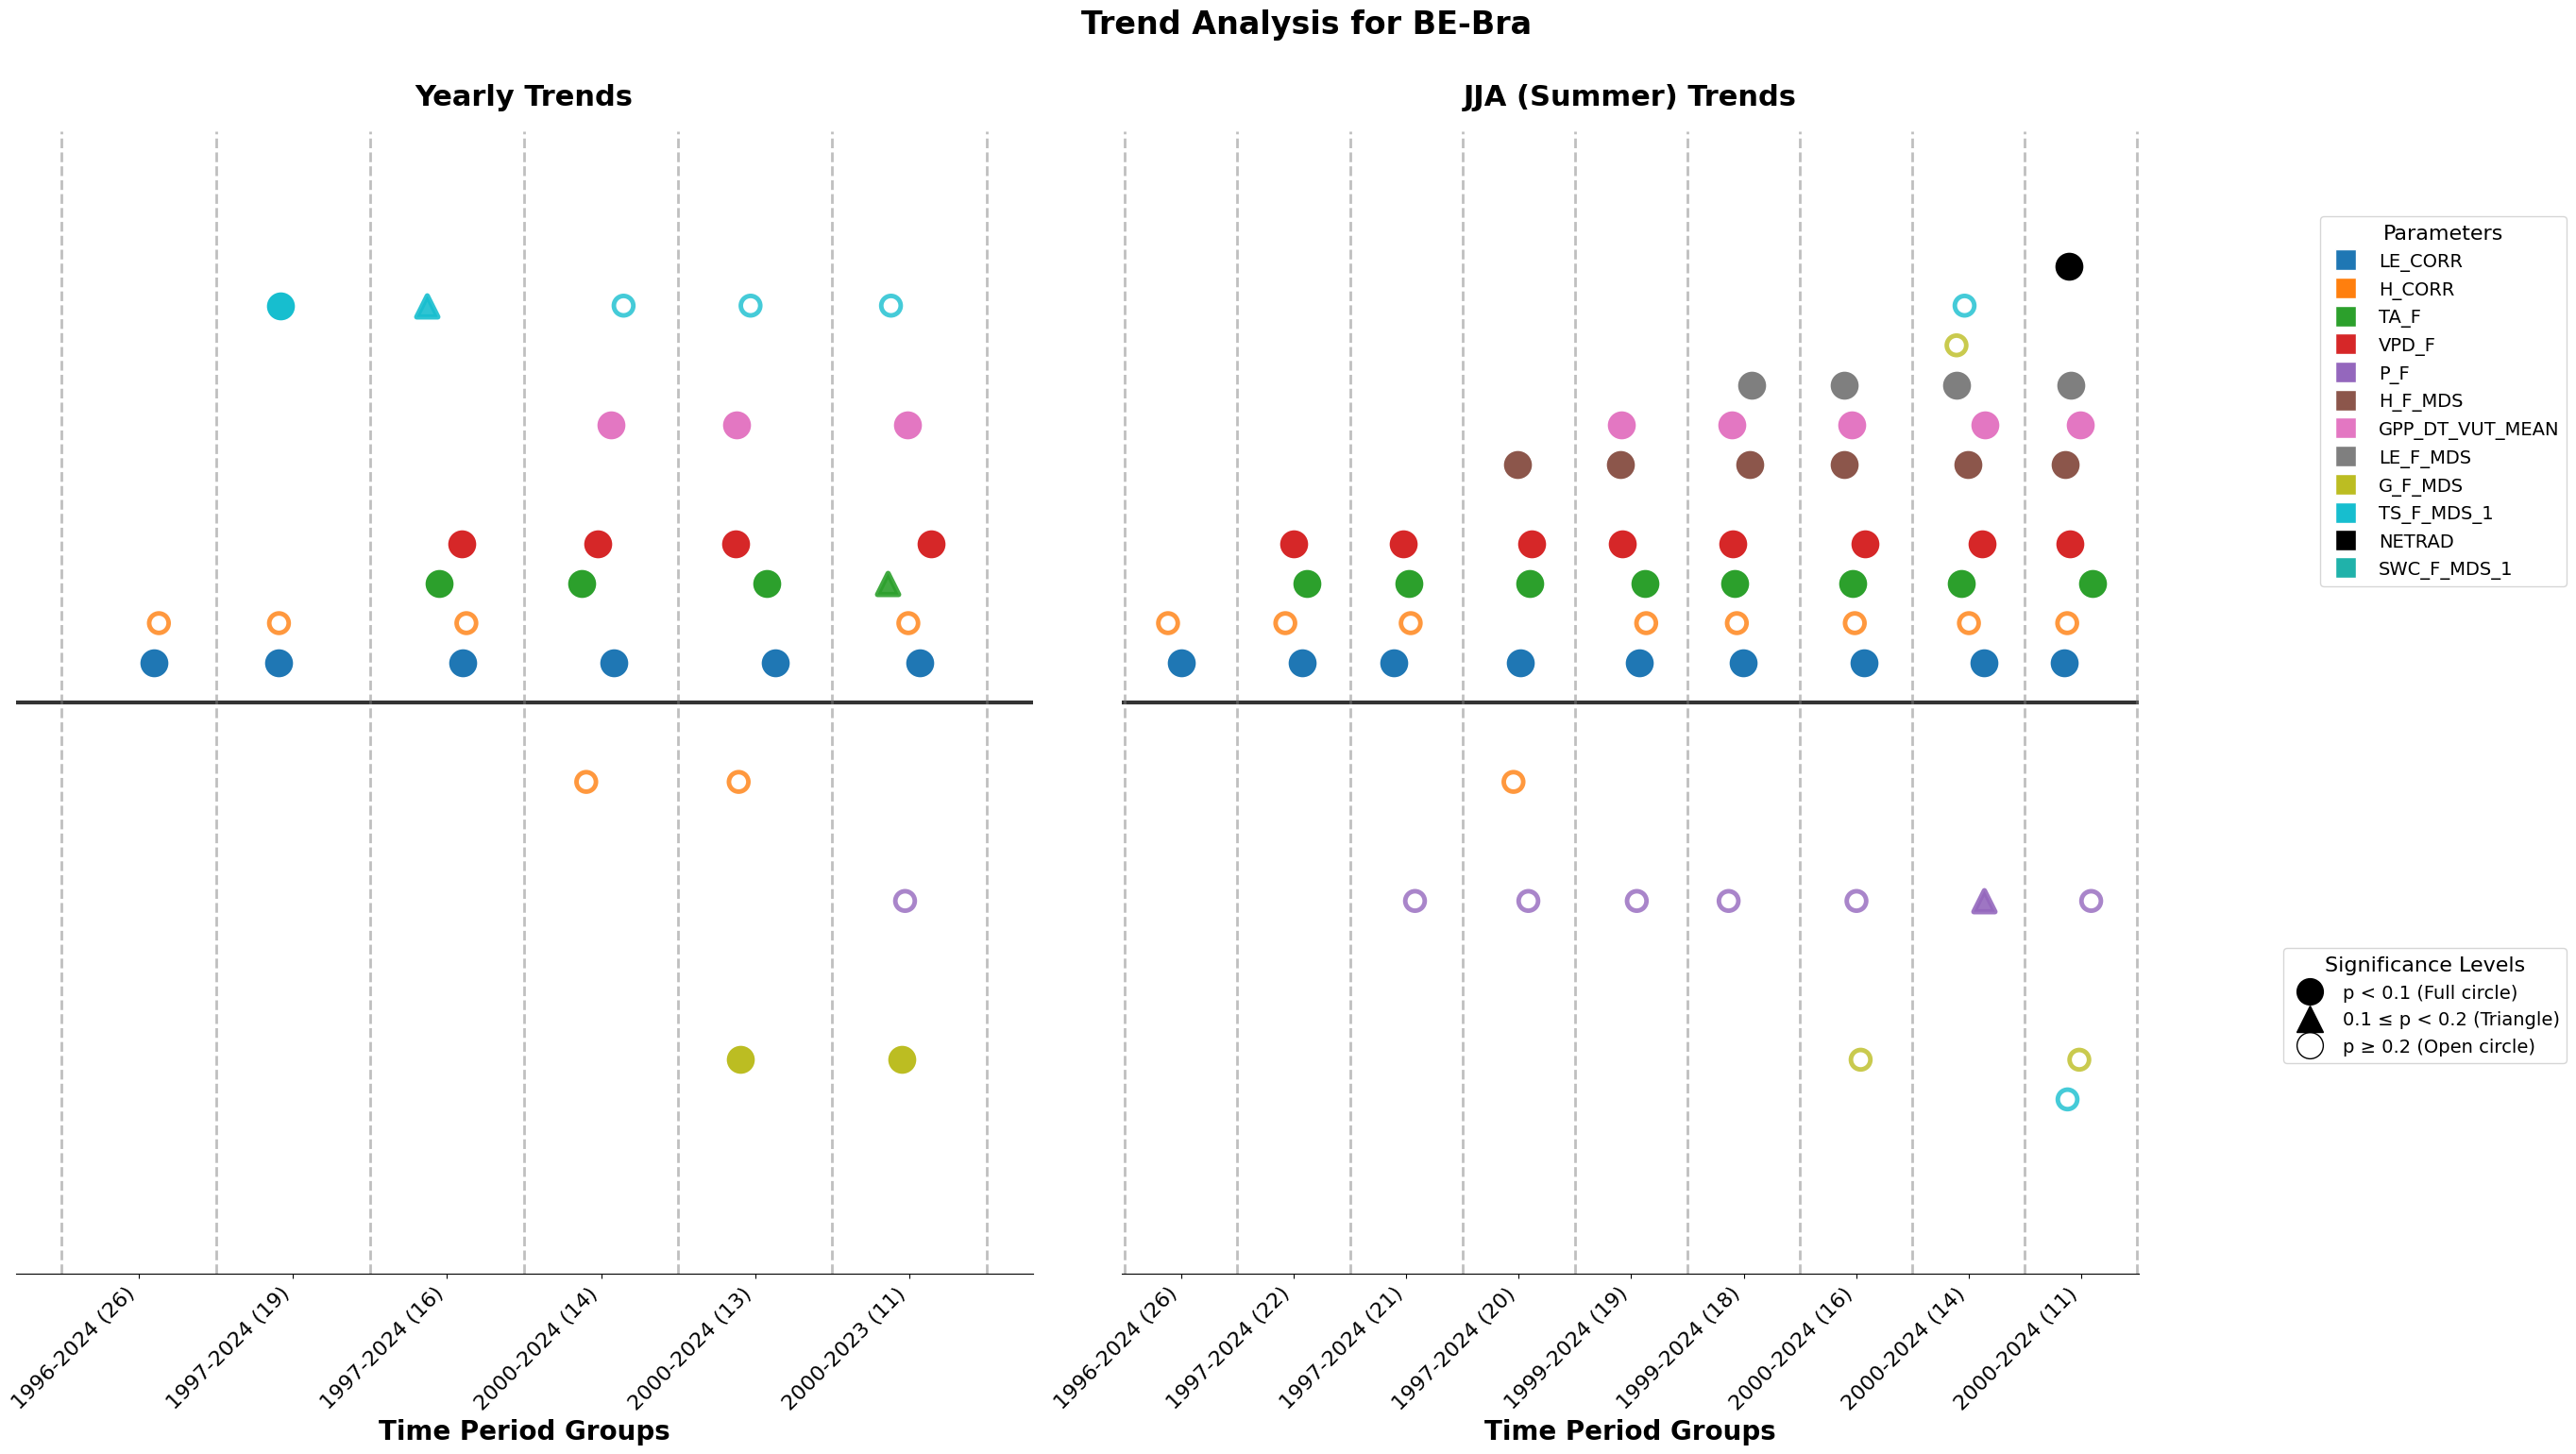

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D

# Define parameters and assign fixed colors
color_dict = {
    'LE_CORR': '#1f77b4',          # blue
    'H_CORR': '#ff7f0e',           # orange
    'TA_F': '#2ca02c',             # green
    'VPD_F': '#d62728',            # red
    'P_F': '#9467bd',              # purple
    'H_F_MDS': '#8c564b',          # brown
    'GPP_DT_VUT_MEAN': '#e377c2',  # pink
    'LE_F_MDS': '#7f7f7f',         # gray
    'G_F_MDS': '#bcbd22',          # olive
    'TS_F_MDS_1': '#17becf',       # teal
    'NETRAD': '#000000',           # black
    'SWC_F_MDS_1': '#20B2AA'       # light sea green
}

parameters = list(color_dict.keys())

# Fixed absolute Y positions for each parameter (distance from zero line)
# Increased distances for better separation
parameter_distances = {
    'LE_CORR': 0.2,
    'H_CORR': 0.4,
    'TA_F': 0.6,
    'VPD_F': 0.8,
    'P_F': 1.0,
    'H_F_MDS': 1.2,
    'GPP_DT_VUT_MEAN': 1.4,
    'LE_F_MDS': 1.6,
    'G_F_MDS': 1.8,
    'TS_F_MDS_1': 2.0,
    'NETRAD': 2.2,
    'SWC_F_MDS_1': 2.4
}

# Directory containing Excel files
input_directory = r'C:\Deepak\stations\MM\Final1\yearly'
output_directory = r'C:\Deepak\stations\MM\Final1\yearly\plots'

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Get list of Excel files - separate yearly and JJA files
yearly_files = [f for f in os.listdir(input_directory) if f.endswith('_yearly.xlsx')]
jja_files = [f for f in os.listdir(input_directory) if f.endswith('_JJA.xlsx')]

# Create a mapping between yearly and JJA files
file_pairs = {}
for y_file in yearly_files:
    base_name = y_file.replace('_yearly.xlsx', '')
    jja_file = base_name + '_JJA.xlsx'
    if jja_file in jja_files:
        file_pairs[base_name] = {'yearly': y_file, 'jja': jja_file}
    else:
        file_pairs[base_name] = {'yearly': y_file, 'jja': None}

# Also include JJA files that don't have yearly counterparts
for j_file in jja_files:
    base_name = j_file.replace('_JJA.xlsx', '')
    if base_name not in file_pairs:
        file_pairs[base_name] = {'yearly': None, 'jja': j_file}

# Process each file pair
for base_name, files in file_pairs.items():
    try:
        # Create figure with two subplots side by side - INCREASED FIGURE SIZE
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 16))
        axes = [ax1, ax2]
        
        # Titles for each subplot
        plot_titles = ['Yearly Trends', 'JJA (Summer) Trends']
        data_loaded = [False, False]
        
        # Process yearly data (left plot)
        if files['yearly']:
            yearly_file_path = os.path.join(input_directory, files['yearly'])
            try:
                p_values_df_yearly = pd.read_excel(yearly_file_path, sheet_name='P-values')
                slopes_df_yearly = pd.read_excel(yearly_file_path, sheet_name='Slopes')
                
                # Clean the data
                p_values_df_yearly = p_values_df_yearly.dropna(how='all')
                slopes_df_yearly = slopes_df_yearly.dropna(how='all')
                p_values_df_yearly = p_values_df_yearly.reset_index(drop=True)
                slopes_df_yearly = slopes_df_yearly.reset_index(drop=True)
                
                years = slopes_df_yearly['Years'].values
                data_loaded[0] = True
                
                # Plot yearly data
                ax = ax1
                for year_idx, year in enumerate(years):
                    for param in parameters:
                        if param not in slopes_df_yearly.columns or param not in p_values_df_yearly.columns:
                            continue
                            
                        slope = slopes_df_yearly[param].iloc[year_idx]
                        p_val = p_values_df_yearly[param].iloc[year_idx]

                        if pd.isna(p_val) or pd.isna(slope):
                            continue

                        # FIXED POSITION: Use the predefined distance from zero
                        # If slope is positive: above zero (positive Y)
                        # If slope is negative: below zero (negative Y)
                        base_distance = parameter_distances[param]
                        y_position = base_distance if slope >= 0 else -base_distance
                        
                        x_position = year_idx  # Center on the year position
                        
                        # Small random offset to avoid perfect alignment
                        x_offset = np.random.uniform(-0.15, 0.15)
                        x_position += x_offset

                        # Marker rules based on p-values - INCREASED SIZES
                        if p_val < 0.1:
                            marker = 'o'   # full circle
                            marker_size = 300  # Increased from 180
                            fill_style = 'full'
                            edge_width = 4.0   # Increased from 2.5
                            alpha_val = 1.0
                        elif p_val < 0.2:
                            marker = '^'   # triangle
                            marker_size = 260  # Increased from 160
                            fill_style = 'full'
                            edge_width = 4.0   # Increased from 2.5
                            alpha_val = 0.9
                        else:
                            marker = 'o'   # open circle
                            marker_size = 220  # Increased from 140
                            fill_style = 'none'
                            edge_width = 3.5   # Increased from 2.0
                            alpha_val = 0.8

                        # Plot marker
                        ax.scatter(x_position, y_position, s=marker_size,
                                   c=color_dict[param] if fill_style == 'full' else 'none',
                                   marker=marker, edgecolors=color_dict[param],
                                   linewidths=edge_width, alpha=alpha_val, zorder=5)
                
                # Customize yearly plot - INCREASED FONT SIZES
                ax.set_xlabel('Time Period Groups', fontsize=20, fontweight='bold')  # Increased from 16
                ax.set_xticks(range(len(years)))
                ax.set_xticklabels(years, rotation=45, ha='right', fontsize=16)  # Increased from 13
                ax.set_title(plot_titles[0], fontsize=22, fontweight='bold', pad=20)  # Increased from 18
                
            except Exception as e:
                print(f"Error loading yearly data for {base_name}: {str(e)}")
                ax1.text(0.5, 0.5, 'Yearly data\nnot available', 
                        ha='center', va='center', transform=ax1.transAxes, fontsize=20)  # Increased from 16
        
        else:
            ax1.text(0.5, 0.5, 'Yearly data\nnot available', 
                    ha='center', va='center', transform=ax1.transAxes, fontsize=20)  # Increased from 16
        
        # Process JJA data (right plot)
        if files['jja']:
            jja_file_path = os.path.join(input_directory, files['jja'])
            try:
                p_values_df_jja = pd.read_excel(jja_file_path, sheet_name='P-values')
                slopes_df_jja = pd.read_excel(jja_file_path, sheet_name='Slopes')
                
                # Clean the data
                p_values_df_jja = p_values_df_jja.dropna(how='all')
                slopes_df_jja = slopes_df_jja.dropna(how='all')
                p_values_df_jja = p_values_df_jja.reset_index(drop=True)
                slopes_df_jja = slopes_df_jja.reset_index(drop=True)
                
                years_jja = slopes_df_jja['Years'].values
                data_loaded[1] = True
                
                # Plot JJA data
                ax = ax2
                for year_idx, year in enumerate(years_jja):
                    for param in parameters:
                        if param not in slopes_df_jja.columns or param not in p_values_df_jja.columns:
                            continue
                            
                        slope = slopes_df_jja[param].iloc[year_idx]
                        p_val = p_values_df_jja[param].iloc[year_idx]

                        if pd.isna(p_val) or pd.isna(slope):
                            continue

                        # FIXED POSITION: Same logic as yearly plot
                        base_distance = parameter_distances[param]
                        y_position = base_distance if slope >= 0 else -base_distance
                        
                        x_position = year_idx
                        x_offset = np.random.uniform(-0.15, 0.15)
                        x_position += x_offset

                        # Marker rules based on p-values - INCREASED SIZES
                        if p_val < 0.1:
                            marker = 'o'   # full circle
                            marker_size = 300  # Increased from 180
                            fill_style = 'full'
                            edge_width = 4.0   # Increased from 2.5
                            alpha_val = 1.0
                        elif p_val < 0.2:
                            marker = '^'   # triangle
                            marker_size = 260  # Increased from 160
                            fill_style = 'full'
                            edge_width = 4.0   # Increased from 2.5
                            alpha_val = 0.9
                        else:
                            marker = 'o'   # open circle
                            marker_size = 220  # Increased from 140
                            fill_style = 'none'
                            edge_width = 3.5   # Increased from 2.0
                            alpha_val = 0.8

                        # Plot marker
                        ax.scatter(x_position, y_position, s=marker_size,
                                   c=color_dict[param] if fill_style == 'full' else 'none',
                                   marker=marker, edgecolors=color_dict[param],
                                   linewidths=edge_width, alpha=alpha_val, zorder=5)
                
                # Customize JJA plot - INCREASED FONT SIZES
                ax.set_xlabel('Time Period Groups', fontsize=20, fontweight='bold')  # Increased from 16
                ax.set_xticks(range(len(years_jja)))
                ax.set_xticklabels(years_jja, rotation=45, ha='right', fontsize=16)  # Increased from 13
                ax.set_title(plot_titles[1], fontsize=22, fontweight='bold', pad=20)  # Increased from 18
                
            except Exception as e:
                print(f"Error loading JJA data for {base_name}: {str(e)}")
                ax2.text(0.5, 0.5, 'JJA data\nnot available', 
                        ha='center', va='center', transform=ax2.transAxes, fontsize=20)  # Increased from 16
        
        else:
            ax2.text(0.5, 0.5, 'JJA data\nnot available', 
                    ha='center', va='center', transform=ax2.transAxes, fontsize=20)  # Increased from 16
        
        # Common plot elements for both subplots
        for ax in axes:
            # Set y-axis limits based on maximum distance
            max_distance = max(parameter_distances.values())
            y_limit = max_distance * 1.2  # Add some padding
            ax.set_ylim(-y_limit, y_limit)
            
            # Remove y-axis labels and ticks as requested
            ax.set_yticks([])
            ax.set_ylabel('')
            
            # Zero line - INCREASED THICKNESS
            ax.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=3, zorder=1)  # Increased from 2
            
            # Customize spines
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_visible(False)

            # Add vertical lines to separate year groups - INCREASED VISIBILITY
            if ax == ax1 and data_loaded[0]:
                years_to_use = years
            elif ax == ax2 and data_loaded[1]:
                years_to_use = years_jja
            else:
                years_to_use = []
            
            for i in range(len(years_to_use) + 1):
                ax.axvline(x=i - 0.5, color='gray', linestyle='--', alpha=0.5, linewidth=2, zorder=1)  # Increased visibility

            # Add grid for better readability - INCREASED VISIBILITY
            ax.grid(True, axis='y', linestyle='--', alpha=0.4, linewidth=1.2, zorder=1)  # Increased visibility

        # Main title - INCREASED SIZE
        display_name = base_name.replace("progressive_trend_tables_", "")
        plt.suptitle(f'Trend Analysis for {display_name}',
                    fontsize=24, fontweight='bold', y=0.96)  # Increased from 20

        # Create common legends (outside the right subplot) - INCREASED SIZES
        legend_elements = [
            Line2D([0], [0], marker='s', color='w',
                   markerfacecolor=color_dict[param],
                   markersize=16, label=param)  # Increased from 12
            for param in parameters
        ]

        marker_elements = [
            Line2D([0], [0], marker='o', color='black', markerfacecolor='black',
                   markersize=20, linestyle='None', label='p < 0.1 (Full circle)'),  # Increased from 15
            Line2D([0], [0], marker='^', color='black', markerfacecolor='black',
                   markersize=20, linestyle='None', label='0.1 ≤ p < 0.2 (Triangle)'),  # Increased from 15
            Line2D([0], [0], marker='o', color='black', markerfacecolor='none',
                   markersize=20, linestyle='None', label='p ≥ 0.2 (Open circle)')  # Increased from 15
        ]

        # Place legends - INCREASED FONT SIZES
        legend1 = fig.legend(handles=legend_elements, 
                           loc='center right',
                           bbox_to_anchor=(0.98, 0.7),
                           fontsize=14,  # Increased from 12
                           title='Parameters', 
                           title_fontsize=16)  # Increased from 13

        legend2 = fig.legend(handles=marker_elements, 
                           loc='center right',
                           bbox_to_anchor=(0.98, 0.3),
                           fontsize=14,  # Increased from 12
                           title='Significance Levels', 
                           title_fontsize=16)  # Increased from 13

        # Adjust layout for larger elements
        plt.tight_layout(rect=[0, 0, 0.82, 0.95])  # Adjusted for larger legends
        
        # Save the plot with high DPI
        output_path = os.path.join(output_directory, f"{display_name}_side_by_side_plot.png")
        plt.savefig(output_path, dpi=350, bbox_inches='tight')  # Increased DPI from 300
        plt.close()
        
        print(f"Side-by-side plot saved for {display_name}")
        
    except Exception as e:
        print(f"Error processing {base_name}: {str(e)}")
        import traceback
        print(traceback.format_exc())

print("All files processed!")

In [ ]:
stations_to_process = [
    'AT-Neu', 'BE-Bra', 'BE-Lon', 'BE-Vie', 'CH-Cha', 'CH-Dav', 'CH-Fru', 
    'CZ-BK1', 'CZ-wet', 'DE-Geb', 'DE-Gri', 'DE-Hai', 'DE-HoH', 'DE-Hzd', 
    'DE-Kli', 'DE-Lnf', 'DE-Obe', 'DE-RuR', 'DE-RuS', 'DE-Tha', 'DK-Sor', 
    'ES-Agu', 'ES-LJu', 'FI-Hyy', 'FI-Let', 'FI-Sod', 'FR-Aur', 'FR-Bil', 
    'FR-Gri', 'FR-Hes', 'FR-Lam', 'FR-LBr', 'IL-Yat', 'IT-BCi', 'IT-Col', 
    'IT-Cp2', 'IT-Cpz', 'IT-Lav', 'IT-MBo', 'IT-Ren', 'IT-Ro2', 'IT-SR2', 
    'IT-SRo', 'IT-Tor', 'IT-TrF', 'NL-Loo', 'RU-Fyo', 'SE-Deg', 'SE-Htm', 
    'SE-Nor', 'SE-Svb'
]

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle, FancyBboxPatch
import matplotlib.patches as mpatches
from matplotlib_venn import venn2, venn3
import seaborn as sns

# Define parameters and assign fixed colors
color_dict = {
    'LE_CORR': '#1f77b4',          # blue
    'H_CORR': '#ff7f0e',           # orange
    'TA_F': '#2ca02c',             # green
    'VPD_F': '#d62728',            # red
    'P_F': '#9467bd',              # purple
    'H_F_MDS': '#8c564b',          # brown
    'GPP_DT_VUT_MEAN': '#e377c2',  # pink
    'LE_F_MDS': '#7f7f7f',         # gray
    'G_F_MDS': '#bcbd22',          # olive
    'TS_F_MDS_1': '#17becf',       # teal
    'NETRAD': '#000000',           # black
    'SWC_F_MDS_1': '#20B2AA'       # light sea green
}

parameters = list(color_dict.keys())

# Fixed absolute Y positions for each parameter (distance from zero line)
parameter_distances = {
    'LE_CORR': 0.2,
    'H_CORR': 0.4,
    'TA_F': 0.6,
    'VPD_F': 0.8,
    'P_F': 1.0,
    'H_F_MDS': 1.2,
    'GPP_DT_VUT_MEAN': 1.4,
    'LE_F_MDS': 1.6,
    'G_F_MDS': 1.8,
    'TS_F_MDS_1': 2.0,
    'NETRAD': 2.2,
    'SWC_F_MDS_1': 2.4
}

# Directory containing Excel files
input_directory = r'C:\Deepak\stations\MM\Final1\yearly'
output_directory = r'C:\Deepak\stations\MM\Final1\yearly\plots_final'

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Global storage for significance data across all stations
all_stations_significance = {param: {'high_sig': 0, 'medium_sig': 0, 'insig': 0, 'total': 0} 
                           for param in parameters}
all_stations_sig_records = []

# Get list of Excel files - separate yearly and JJA files
yearly_files = [f for f in os.listdir(input_directory) if f.endswith('_yearly.xlsx')]
jja_files = [f for f in os.listdir(input_directory) if f.endswith('_JJA.xlsx')]

# Create a mapping between yearly and JJA files
file_pairs = {}
for y_file in yearly_files:
    base_name = y_file.replace('_yearly.xlsx', '')
    jja_file = base_name + '_JJA.xlsx'
    if jja_file in jja_files:
        file_pairs[base_name] = {'yearly': y_file, 'jja': jja_file}
    else:
        file_pairs[base_name] = {'yearly': y_file, 'jja': None}

# Also include JJA files that don't have yearly counterparts
for j_file in jja_files:
    base_name = j_file.replace('_JJA.xlsx', '')
    if base_name not in file_pairs:
        file_pairs[base_name] = {'yearly': None, 'jja': j_file}

def calculate_score_and_selection(p_values_df, slopes_df, parameters):
    """Calculate scores and determine selected periods based on highest scores"""
    scores_by_period = {}
    
    for period_idx in range(len(p_values_df)):
        period_score = 0
        sig_count = 0
        
        for param in parameters:
            if param not in p_values_df.columns or param not in slopes_df.columns:
                continue
                
            p_val = p_values_df[param].iloc[period_idx]
            slope = slopes_df[param].iloc[period_idx]
            
            if pd.isna(p_val) or pd.isna(slope):
                continue
            
            # Calculate score based on significance
            if p_val < 0.1:
                period_score += 1
                sig_count += 1
            elif p_val < 0.2:
                period_score += 0.5
                sig_count += 1
            else:
                period_score += 0.1
        
        scores_by_period[period_idx] = {
            'score': period_score,
            'sig_count': sig_count,
            'period_name': slopes_df['Years'].iloc[period_idx] if 'Years' in slopes_df.columns else f'Period_{period_idx}'
        }
    
    # Select period with highest score (tie-breaker: most significant counts)
    if scores_by_period:
        selected_period = max(scores_by_period.keys(), 
                            key=lambda x: (scores_by_period[x]['score'], 
                                         scores_by_period[x]['sig_count']))
        return scores_by_period, selected_period
    return {}, None

def update_global_significance(station_name, p_values_df, slopes_df, parameters, season):
    """Update global significance counters for comprehensive bar plot"""
    for param in parameters:
        if param not in p_values_df.columns:
            continue
            
        for period_idx in range(len(p_values_df)):
            p_val = p_values_df[param].iloc[period_idx]
            slope = slopes_df[param].iloc[period_idx] if param in slopes_df.columns else None
            
            if pd.isna(p_val) or pd.isna(slope):
                continue
            
            # Count for comprehensive statistics
            all_stations_significance[param]['total'] += 1
            
            if p_val < 0.1:
                all_stations_significance[param]['high_sig'] += 1
                sig_level = 'high'
            elif p_val < 0.2:
                all_stations_significance[param]['medium_sig'] += 1
                sig_level = 'medium'
            else:
                all_stations_significance[param]['insig'] += 1
                sig_level = 'insig'
            
            # Store record for Venn diagrams
            if p_val < 0.2:  # Only store significant records (0.9 or 0.5)
                all_stations_sig_records.append({
                    'station': station_name,
                    'parameter': param,
                    'season': season,
                    'significance': sig_level,
                    'p_value': p_val,
                    'slope': slope
                })

def create_comprehensive_bar_plot():
    """Create a comprehensive bar plot showing significance distribution for all variables"""
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # Prepare data for stacked bar plot
    params = list(all_stations_significance.keys())
    high_sig = [all_stations_significance[param]['high_sig'] for param in params]
    medium_sig = [all_stations_significance[param]['medium_sig'] for param in params]
    insig = [all_stations_significance[param]['insig'] for param in params]
    
    # Create stacked bar plot
    bar_width = 0.8
    x_pos = np.arange(len(params))
    
    bars1 = ax.bar(x_pos, high_sig, bar_width, label='Highly Significant (p < 0.1)', 
                   color='#2ca02c', edgecolor='black', linewidth=1)
    bars2 = ax.bar(x_pos, medium_sig, bar_width, bottom=high_sig, 
                   label='Moderately Significant (0.1 ≤ p < 0.2)', 
                   color='#ff7f0e', edgecolor='black', linewidth=1)
    bars3 = ax.bar(x_pos, insig, bar_width, bottom=np.array(high_sig) + np.array(medium_sig),
                   label='Not Significant (p ≥ 0.2)', 
                   color='#d62728', edgecolor='black', linewidth=1)
    
    # Add value labels on bars
    for i, (h, m, n) in enumerate(zip(high_sig, medium_sig, insig)):
        total = h + m + n
        if total > 0:
            ax.text(i, total + 0.1, f'{total}', ha='center', va='bottom', fontweight='bold')
    
    # Customize plot
    ax.set_xlabel('Parameters', fontsize=14, fontweight='bold')
    ax.set_ylabel('Count of Significant Periods', fontsize=14, fontweight='bold')
    ax.set_title('Comprehensive Significance Analysis Across All Stations and Periods', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(params, rotation=45, ha='right')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, 'comprehensive_significance_analysis.png'), 
                dpi=300, bbox_inches='tight')
    plt.close()

def create_venn_diagrams():
    """Create Venn diagrams for significant station intersections"""
    
    # Filter significant records
    sig_df = pd.DataFrame(all_stations_sig_records)
    if len(sig_df) == 0:
        print("No significant records found for Venn diagrams")
        return
    
    # Group by station and parameter to get stations with at least one significant period
    station_params = sig_df.groupby(['station', 'parameter']).size().reset_index()
    
    # Create sets for different parameter groups
    le_mds_stations = set(station_params[station_params['parameter'] == 'LE_F_MDS']['station'])
    h_mds_stations = set(station_params[station_params['parameter'] == 'H_F_MDS']['station'])
    netrad_stations = set(station_params[station_params['parameter'] == 'NETRAD']['station'])
    le_corr_stations = set(station_params[station_params['parameter'] == 'LE_CORR']['station'])
    h_corr_stations = set(station_params[station_params['parameter'] == 'H_CORR']['station'])
    
    # Create Venn diagrams
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 14))
    
    # Venn 1: LE_MDS, H_MDS, NETRAD
    if le_mds_stations or h_mds_stations or netrad_stations:
        venn3([le_mds_stations, h_mds_stations, netrad_stations],
              ['LE_MDS', 'H_MDS', 'NETRAD'], ax=ax1)
        ax1.set_title('MDS: LE vs H vs Net Radiation', fontsize=14, fontweight='bold')
    
    # Venn 2: LE_CORR, H_CORR, NETRAD
    if le_corr_stations or h_corr_stations or netrad_stations:
        venn3([le_corr_stations, h_corr_stations, netrad_stations],
              ['LE_CORR', 'H_CORR', 'NETRAD'], ax=ax2)
        ax2.set_title('CORR: LE vs H vs Net Radiation', fontsize=14, fontweight='bold')
    
    # Venn 3: LE_MDS vs LE_CORR
    if le_mds_stations or le_corr_stations:
        venn2([le_mds_stations, le_corr_stations],
              ['LE_MDS', 'LE_CORR'], ax=ax3)
        ax3.set_title('LE: MDS vs CORR Methods', fontsize=14, fontweight='bold')
    
    # Venn 4: H_MDS vs H_CORR
    if h_mds_stations or h_corr_stations:
        venn2([h_mds_stations, h_corr_stations],
              ['H_MDS', 'H_CORR'], ax=ax4)
        ax4.set_title('H: MDS vs CORR Methods', fontsize=14, fontweight='bold')
    
    plt.suptitle('Significant Stations Intersection Analysis (p < 0.2)', 
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(output_directory, 'venn_diagrams_significant_stations.png'), 
                dpi=300, bbox_inches='tight')
    plt.close()

# Process each file pair
for base_name, files in file_pairs.items():
    try:
        # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 16))
        axes = [ax1, ax2]
        
        # Titles for each subplot
        plot_titles = ['Yearly Trends', 'JJA (Summer) Trends']
        data_loaded = [False, False]
        selected_periods = [None, None]
        scores_data = [{}, {}]
        
        # Process yearly data (left plot)
        if files['yearly']:
            yearly_file_path = os.path.join(input_directory, files['yearly'])
            try:
                p_values_df_yearly = pd.read_excel(yearly_file_path, sheet_name='P-values')
                slopes_df_yearly = pd.read_excel(yearly_file_path, sheet_name='Slopes')
                
                # Clean the data
                p_values_df_yearly = p_values_df_yearly.dropna(how='all')
                slopes_df_yearly = slopes_df_yearly.dropna(how='all')
                p_values_df_yearly = p_values_df_yearly.reset_index(drop=True)
                slopes_df_yearly = slopes_df_yearly.reset_index(drop=True)
                
                years = slopes_df_yearly['Years'].values
                data_loaded[0] = True
                
                # Calculate scores and selection for yearly data
                scores_data[0], selected_periods[0] = calculate_score_and_selection(
                    p_values_df_yearly, slopes_df_yearly, parameters)
                
                # Update global significance data
                update_global_significance(base_name, p_values_df_yearly, slopes_df_yearly, 
                                         parameters, 'yearly')
                
                # Plot yearly data
                ax = ax1
                for year_idx, year in enumerate(years):
                    for param in parameters:
                        if param not in slopes_df_yearly.columns or param not in p_values_df_yearly.columns:
                            continue
                            
                        slope = slopes_df_yearly[param].iloc[year_idx]
                        p_val = p_values_df_yearly[param].iloc[year_idx]

                        if pd.isna(p_val) or pd.isna(slope):
                            continue

                        # FIXED POSITION: Use the predefined distance from zero
                        base_distance = parameter_distances[param]
                        y_position = base_distance if slope >= 0 else -base_distance
                        
                        x_position = year_idx  # Center on the year position
                        
                        # Small random offset to avoid perfect alignment
                        x_offset = np.random.uniform(-0.15, 0.15)
                        x_position += x_offset

                        # Marker rules based on p-values
                        if p_val < 0.1:
                            marker = 'o'   # full circle
                            marker_size = 300
                            fill_style = 'full'
                            edge_width = 4.0
                            alpha_val = 1.0
                        elif p_val < 0.2:
                            marker = '^'   # triangle
                            marker_size = 260
                            fill_style = 'full'
                            edge_width = 4.0
                            alpha_val = 0.9
                        else:
                            marker = 'o'   # open circle
                            marker_size = 220
                            fill_style = 'none'
                            edge_width = 3.5
                            alpha_val = 0.8

                        # Plot marker
                        ax.scatter(x_position, y_position, s=marker_size,
                                   c=color_dict[param] if fill_style == 'full' else 'none',
                                   marker=marker, edgecolors=color_dict[param],
                                   linewidths=edge_width, alpha=alpha_val, zorder=5)
                
                # Highlight selected period with a box
                if selected_periods[0] is not None:
                    selected_idx = selected_periods[0]
                    box = FancyBboxPatch((selected_idx - 0.5, -max(parameter_distances.values()) * 1.1),
                                        width=1, height=max(parameter_distances.values()) * 2.2,
                                        boxstyle="round,pad=0.02", 
                                        linewidth=4, edgecolor='red', facecolor='none', 
                                        alpha=0.8, zorder=10)
                    ax.add_patch(box)
                    
                    # Add annotation for selected period
                    score_info = scores_data[0][selected_idx]
                    #ax.text(selected_idx, max(parameter_distances.values()) * 1.15,
                       #    f"Selected\nScore: {score_info['score']:.1f}\nSigs: {score_info['sig_count']}",
                       #    ha='center', va='bottom', fontsize=10, fontweight='bold',
                       #    bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7))
                
                # Customize yearly plot
                ax.set_xlabel('Time Period Groups', fontsize=20, fontweight='bold')
                ax.set_xticks(range(len(years)))
                ax.set_xticklabels(years, rotation=45, ha='right', fontsize=16)
                ax.set_title(plot_titles[0], fontsize=22, fontweight='bold', pad=20)
                
            except Exception as e:
                print(f"Error loading yearly data for {base_name}: {str(e)}")
                ax1.text(0.5, 0.5, 'Yearly data\nnot available', 
                        ha='center', va='center', transform=ax1.transAxes, fontsize=20)
        
        else:
            ax1.text(0.5, 0.5, 'Yearly data\nnot available', 
                    ha='center', va='center', transform=ax1.transAxes, fontsize=20)
        
        # Process JJA data (right plot)
        if files['jja']:
            jja_file_path = os.path.join(input_directory, files['jja'])
            try:
                p_values_df_jja = pd.read_excel(jja_file_path, sheet_name='P-values')
                slopes_df_jja = pd.read_excel(jja_file_path, sheet_name='Slopes')
                
                # Clean the data
                p_values_df_jja = p_values_df_jja.dropna(how='all')
                slopes_df_jja = slopes_df_jja.dropna(how='all')
                p_values_df_jja = p_values_df_jja.reset_index(drop=True)
                slopes_df_jja = slopes_df_jja.reset_index(drop=True)
                
                years_jja = slopes_df_jja['Years'].values
                data_loaded[1] = True
                
                # Calculate scores and selection for JJA data
                scores_data[1], selected_periods[1] = calculate_score_and_selection(
                    p_values_df_jja, slopes_df_jja, parameters)
                
                # Update global significance data
                update_global_significance(base_name, p_values_df_jja, slopes_df_jja, 
                                         parameters, 'jja')
                
                # Plot JJA data
                ax = ax2
                for year_idx, year in enumerate(years_jja):
                    for param in parameters:
                        if param not in slopes_df_jja.columns or param not in p_values_df_jja.columns:
                            continue
                            
                        slope = slopes_df_jja[param].iloc[year_idx]
                        p_val = p_values_df_jja[param].iloc[year_idx]

                        if pd.isna(p_val) or pd.isna(slope):
                            continue

                        # FIXED POSITION: Same logic as yearly plot
                        base_distance = parameter_distances[param]
                        y_position = base_distance if slope >= 0 else -base_distance
                        
                        x_position = year_idx
                        x_offset = np.random.uniform(-0.15, 0.15)
                        x_position += x_offset

                        # Marker rules based on p-values
                        if p_val < 0.1:
                            marker = 'o'   # full circle
                            marker_size = 300
                            fill_style = 'full'
                            edge_width = 4.0
                            alpha_val = 1.0
                        elif p_val < 0.2:
                            marker = '^'   # triangle
                            marker_size = 260
                            fill_style = 'full'
                            edge_width = 4.0
                            alpha_val = 0.9
                        else:
                            marker = 'o'   # open circle
                            marker_size = 220
                            fill_style = 'none'
                            edge_width = 3.5
                            alpha_val = 0.8

                        # Plot marker
                        ax.scatter(x_position, y_position, s=marker_size,
                                   c=color_dict[param] if fill_style == 'full' else 'none',
                                   marker=marker, edgecolors=color_dict[param],
                                   linewidths=edge_width, alpha=alpha_val, zorder=5)
                
                # Highlight selected period with a box
                if selected_periods[1] is not None:
                    selected_idx = selected_periods[1]
                    box = FancyBboxPatch((selected_idx - 0.5, -max(parameter_distances.values()) * 1.1),
                                        width=1, height=max(parameter_distances.values()) * 2.2,
                                        boxstyle="round,pad=0.02", 
                                        linewidth=4, edgecolor='red', facecolor='none', 
                                        alpha=0.8, zorder=10)
                    ax.add_patch(box)
                    
                    # Add annotation for selected period
                    score_info = scores_data[1][selected_idx]
                    #ax.text(selected_idx, max(parameter_distances.values()) * 1.15,
                       #    f"Selected\nScore: {score_info['score']:.1f}\nSigs: {score_info['sig_count']}",
                       #    ha='center', va='bottom', fontsize=10, fontweight='bold',
                       #    bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7))
                
                # Customize JJA plot
                ax.set_xlabel('Time Period Groups', fontsize=20, fontweight='bold')
                ax.set_xticks(range(len(years_jja)))
                ax.set_xticklabels(years_jja, rotation=45, ha='right', fontsize=16)
                ax.set_title(plot_titles[1], fontsize=22, fontweight='bold', pad=20)
                
            except Exception as e:
                print(f"Error loading JJA data for {base_name}: {str(e)}")
                ax2.text(0.5, 0.5, 'JJA data\nnot available', 
                        ha='center', va='center', transform=ax2.transAxes, fontsize=20)
        
        else:
            ax2.text(0.5, 0.5, 'JJA data\nnot available', 
                    ha='center', va='center', transform=ax2.transAxes, fontsize=20)
        
        # Common plot elements for both subplots
        for ax_idx, ax in enumerate(axes):
            # Set y-axis limits based on maximum distance
            max_distance = max(parameter_distances.values())
            y_limit = max_distance * 1.2  # Add some padding
            ax.set_ylim(-y_limit, y_limit)
            
            # Remove y-axis labels and ticks as requested
            ax.set_yticks([])
            ax.set_ylabel('')
            
            # Zero line
            ax.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=3, zorder=1)
            
            # Customize spines
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_visible(False)

            # Add vertical lines to separate year groups
            if ax == ax1 and data_loaded[0]:
                years_to_use = years
            elif ax == ax2 and data_loaded[1]:
                years_to_use = years_jja
            else:
                years_to_use = []
            
            for i in range(len(years_to_use) + 1):
                ax.axvline(x=i - 0.5, color='gray', linestyle='--', alpha=0.5, linewidth=2, zorder=1)

            # Add grid for better readability
            ax.grid(True, axis='y', linestyle='--', alpha=0.4, linewidth=1.2, zorder=1)

        # Main title
        display_name = base_name.replace("progressive_trend_tables_", "")
        plt.suptitle(f'Trend Analysis for {display_name}',
                    fontsize=24, fontweight='bold', y=0.96)

        # Create common legends (outside the right subplot)
        legend_elements = [
            Line2D([0], [0], marker='s', color='w',
                   markerfacecolor=color_dict[param],
                   markersize=16, label=param)
            for param in parameters
        ]

        marker_elements = [
            Line2D([0], [0], marker='o', color='black', markerfacecolor='black',
                   markersize=20, linestyle='None', label='p < 0.1 (Full circle)'),
            Line2D([0], [0], marker='^', color='black', markerfacecolor='black',
                   markersize=20, linestyle='None', label='0.1 ≤ p < 0.2 (Triangle)'),
            Line2D([0], [0], marker='o', color='black', markerfacecolor='none',
                   markersize=20, linestyle='None', label='p ≥ 0.2 (Open circle)')
        ]

        # Place legends
        legend1 = fig.legend(handles=legend_elements, 
                           loc='center right',
                           bbox_to_anchor=(0.98, 0.7),
                           fontsize=14,
                           title='Parameters', 
                           title_fontsize=16)

        legend2 = fig.legend(handles=marker_elements, 
                           loc='center right',
                           bbox_to_anchor=(0.98, 0.3),
                           fontsize=14,
                           title='Significance Levels', 
                           title_fontsize=16)

        # Adjust layout for larger elements
        plt.tight_layout(rect=[0, 0, 0.82, 0.95])
        
        # Save the plot with high DPI
        output_path = os.path.join(output_directory, f"{display_name}_side_by_side_plot.png")
        plt.savefig(output_path, dpi=350, bbox_inches='tight')
        plt.close()
        
        print(f"Side-by-side plot saved for {display_name}")
        
    except Exception as e:
        print(f"Error processing {base_name}: {str(e)}")
        import traceback
        print(traceback.format_exc())

# After processing all stations, create comprehensive plots
print("Creating comprehensive analysis plots...")

# Create comprehensive bar plot
create_comprehensive_bar_plot()
print("Comprehensive bar plot created!")

# Create Venn diagrams
create_venn_diagrams()
print("Venn diagrams created!")

print("All files processed!")

Side-by-side plot saved for AT-Neu
Side-by-side plot saved for BE-Bra
Error loading yearly data for progressive_trend_tables_BE-Dor: 'Years'
Error loading JJA data for progressive_trend_tables_BE-Dor: 'Years'
Side-by-side plot saved for BE-Dor
Side-by-side plot saved for BE-Lon
Side-by-side plot saved for BE-Vie
Error loading yearly data for progressive_trend_tables_CH-Aws: 'Years'
Error loading JJA data for progressive_trend_tables_CH-Aws: 'Years'
Side-by-side plot saved for CH-Aws
Side-by-side plot saved for CH-Cha
Side-by-side plot saved for CH-Dav
Side-by-side plot saved for CH-Fru
Side-by-side plot saved for CZ-BK1
Error loading yearly data for progressive_trend_tables_CZ-Lnz: 'Years'
Error loading JJA data for progressive_trend_tables_CZ-Lnz: 'Years'
Side-by-side plot saved for CZ-Lnz
Side-by-side plot saved for CZ-wet
Side-by-side plot saved for DE-Geb
Side-by-side plot saved for DE-Gri
Side-by-side plot saved for DE-Hai
Side-by-side plot saved for DE-HoH
Side-by-side plot saved

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib_venn import venn2, venn3
import seaborn as sns

# Define parameters
parameters = [
    'LE_CORR', 'H_CORR', 'TA_F', 'VPD_F', 'P_F', 'H_F_MDS', 
    'GPP_DT_VUT_MEAN', 'LE_F_MDS', 'G_F_MDS', 'TS_F_MDS_1', 
    'NETRAD', 'SWC_F_MDS_1'
]

# Directory containing Excel files
input_directory = r'C:\Deepak\stations\MM\Final1\yearly'
output_directory = r'C:\Deepak\stations\MM\Final1\yearly\plots7'

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Global storage for significance data across all stations (only selected periods)
all_stations_selected_data = []

# Get list of Excel files - separate yearly and JJA files
yearly_files = [f for f in os.listdir(input_directory) if f.endswith('_yearly.xlsx')]
jja_files = [f for f in os.listdir(input_directory) if f.endswith('_JJA.xlsx')]

# Create a mapping between yearly and JJA files
file_pairs = {}
for y_file in yearly_files:
    base_name = y_file.replace('_yearly.xlsx', '')
    jja_file = base_name + '_JJA.xlsx'
    if jja_file in jja_files:
        file_pairs[base_name] = {'yearly': y_file, 'jja': jja_file}
    else:
        file_pairs[base_name] = {'yearly': y_file, 'jja': None}

# Also include JJA files that don't have yearly counterparts
for j_file in jja_files:
    base_name = j_file.replace('_JJA.xlsx', '')
    if base_name not in file_pairs:
        file_pairs[base_name] = {'yearly': None, 'jja': j_file}

def calculate_score_and_selection(p_values_df, slopes_df, parameters):
    """Calculate scores and determine selected periods based on highest scores"""
    scores_by_period = {}
    
    for period_idx in range(len(p_values_df)):
        period_score = 0
        sig_count = 0
        
        for param in parameters:
            if param not in p_values_df.columns or param not in slopes_df.columns:
                continue
                
            p_val = p_values_df[param].iloc[period_idx]
            slope = slopes_df[param].iloc[period_idx]
            
            if pd.isna(p_val) or pd.isna(slope):
                continue
            
            # Calculate score based on significance
            if p_val < 0.1:
                period_score += 0.9
                sig_count += 1
            elif p_val < 0.2:
                period_score += 0.5
                sig_count += 1
            else:
                period_score += 0.1
        
        scores_by_period[period_idx] = {
            'score': period_score,
            'sig_count': sig_count,
            'period_name': slopes_df['Years'].iloc[period_idx] if 'Years' in slopes_df.columns else f'Period_{period_idx}'
        }
    
    # Select period with highest score (tie-breaker: most significant counts)
    if scores_by_period:
        selected_period = max(scores_by_period.keys(), 
                            key=lambda x: (scores_by_period[x]['score'], 
                                         scores_by_period[x]['sig_count']))
        return scores_by_period, selected_period
    return {}, None

def get_selected_period_data(station_name, p_values_df, slopes_df, parameters, selected_period_idx, season):
    """Get data for the selected period only"""
    selected_data = []
    
    for param in parameters:
        if param not in p_values_df.columns or param not in slopes_df.columns:
            continue
            
        p_val = p_values_df[param].iloc[selected_period_idx]
        slope = slopes_df[param].iloc[selected_period_idx]
        
        if pd.isna(p_val) or pd.isna(slope):
            continue
        
        # Determine significance level
        if p_val < 0.1:
            sig_level = 'high'
            score_contribution = 0.9
        elif p_val < 0.2:
            sig_level = 'medium'
            score_contribution = 0.5
        else:
            sig_level = 'insig'
            score_contribution = 0.1
        
        selected_data.append({
            'station': station_name,
            'parameter': param,
            'season': season,
            'significance': sig_level,
            'p_value': p_val,
            'slope': slope,
            'score_contribution': score_contribution,
            'period': p_values_df['Years'].iloc[selected_period_idx] if 'Years' in p_values_df.columns else f'Period_{selected_period_idx}'
        })
    
    return selected_data

def create_comprehensive_bar_plots_separate_seasons():
    """Create separate comprehensive bar plots for Yearly and JJA seasons"""
    
    # Filter data by season
    yearly_data = [record for record in all_stations_selected_data if record['season'] == 'yearly']
    jja_data = [record for record in all_stations_selected_data if record['season'] == 'JJA']
    
    # Create separate plots for yearly and JJA
    for season, season_data, season_name in [('yearly', yearly_data, 'Yearly'), ('JJA', jja_data, 'JJA (Summer)')]:
        if len(season_data) == 0:
            print(f"No data available for {season_name}")
            continue
            
        # Create summary data for bar plot
        param_summary = {}
        for param in parameters:
            param_summary[param] = {'high_sig': 0, 'medium_sig': 0, 'insig_sig': 0}
        
        for record in season_data:
            param = record['parameter']
            sig_level = record['significance']
            
            # Map significance level to correct key
            if sig_level == 'high':
                key = 'high_sig'
            elif sig_level == 'medium':
                key = 'medium_sig'
            else:  # insig
                key = 'insig_sig'
            
            param_summary[param][key] += 1
        
        # Prepare data for stacked bar plot - REVERSED ORDER
        params = list(param_summary.keys())
        insig = [param_summary[param]['insig_sig'] for param in params]  # Bottom layer
        medium_sig = [param_summary[param]['medium_sig'] for param in params]  # Middle layer
        high_sig = [param_summary[param]['high_sig'] for param in params]  # Top layer
        
        # Create the plot
        fig, ax = plt.subplots(figsize=(16, 10))
        
        bar_width = 0.8
        x_pos = np.arange(len(params))
        
        # Plot in reversed order: Not significant at bottom, then medium, then high
        bars1 = ax.bar(x_pos, insig, bar_width, label='Not Significant (p ≥ 0.2)', 
                       color='#d62728', edgecolor='black', linewidth=1)
        bars2 = ax.bar(x_pos, medium_sig, bar_width, bottom=insig, 
                       label='Moderately Significant (0.1 ≤ p < 0.2)', 
                       color='#ff7f0e', edgecolor='black', linewidth=1)
        bars3 = ax.bar(x_pos, high_sig, bar_width, bottom=np.array(insig) + np.array(medium_sig),
                       label='Highly Significant (p < 0.1)', 
                       color='#2ca02c', edgecolor='black', linewidth=1)
        
        # Add value labels on bars
        for i, (n, m, h) in enumerate(zip(insig, medium_sig, high_sig)):
            total = n + m + h
            if total > 0:
                # Total count at top of bar
                ax.text(i, total + 0.1, f'{total}', ha='center', va='bottom', fontweight='bold', fontsize=10)
                
                # Percentage labels for each segment
                if n > 0:  # Not significant
                    ax.text(i, n/2, f'{n}', ha='center', va='center', 
                           fontweight='bold', fontsize=9, color='white')
                
                if m > 0:  # Moderately significant
                    ax.text(i, n + m/2, f'{m}', ha='center', va='center', 
                           fontweight='bold', fontsize=9, color='white')
                
                if h > 0:  # Highly significant
                    ax.text(i, n + m + h/2, f'{h}', ha='center', va='center', 
                           fontweight='bold', fontsize=9, color='white')
        
        # Customize plot
        ax.set_xlabel('Parameters', fontsize=14, fontweight='bold')
        ax.set_ylabel('Number of Stations', fontsize=14, fontweight='bold')
        ax.set_title(f'Significance Analysis - {season_name} Season', 
                     fontsize=16, fontweight='bold', pad=20)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(params, rotation=45, ha='right', fontsize=12)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
        ax.grid(True, axis='y', alpha=0.3)
        
        # Calculate statistics for annotation
        total_stations = len(set([record['station'] for record in season_data]))
        total_high = sum(high_sig)
        total_medium = sum(medium_sig)
        total_insig = sum(insig)
        total_all = total_high + total_medium + total_insig
        sig_percentage = (total_high + total_medium) / total_all * 100 if total_all > 0 else 0
        
        # Add statistics outside the plot area
        stats_text = (
            f'Total Stations: {total_stations}\n'
            f'Total Parameters: {total_all}\n'
            f'Highly Significant: {total_high} ({total_high/total_all*100:.1f}%)\n'
            f'Moderately Significant: {total_medium} ({total_medium/total_all*100:.1f}%)\n'
            f'Not Significant: {total_insig} ({total_insig/total_all*100:.1f}%)\n'
            f'Overall Significant: {total_high + total_medium}/{total_all} ({sig_percentage:.1f}%)'
        )
        
        # Place statistics on the right side outside the plot
        ax.text(1.02, 0.5, stats_text, transform=ax.transAxes, fontsize=11, 
                fontweight='bold', verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                linespacing=1.5)
        
        # Adjust plot margins to accommodate the statistics text
        plt.subplots_adjust(right=0.75)
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_directory, f'comprehensive_significance_{season}.png'), 
                    dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"Comprehensive bar plot created for {season_name} season")

def create_venn_diagrams_separate_seasons():
    """Create separate Venn diagrams for Yearly and JJA seasons"""
    
    if len(all_stations_selected_data) == 0:
        print("No selected period data found for Venn diagrams")
        return
    
    # Create separate Venn diagrams for yearly and JJA
    for season, season_name in [('yearly', 'Yearly'), ('JJA', 'JJA (Summer)')]:
        # Filter data by season and significance
        season_data = [record for record in all_stations_selected_data if record['season'] == season]
        sig_season_data = [record for record in season_data if record['p_value'] < 0.2]
        
        if len(sig_season_data) == 0:
            print(f"No significant records found for {season_name} Venn diagrams")
            continue
        
        # Create DataFrame for easier manipulation
        sig_df = pd.DataFrame(sig_season_data)
        
        # Group by station and parameter to get stations with at least one significant parameter in selected period
        station_params = sig_df.groupby(['station', 'parameter']).size().reset_index()
        
        # Create sets for different parameter groups
        le_mds_stations = set(station_params[station_params['parameter'] == 'LE_F_MDS']['station'])
        h_mds_stations = set(station_params[station_params['parameter'] == 'H_F_MDS']['station'])
        netrad_stations = set(station_params[station_params['parameter'] == 'NETRAD']['station'])
        le_corr_stations = set(station_params[station_params['parameter'] == 'LE_CORR']['station'])
        h_corr_stations = set(station_params[station_params['parameter'] == 'H_CORR']['station'])
        gpp_stations = set(station_params[station_params['parameter'] == 'GPP_DT_VUT_MEAN']['station'])
        ta_stations = set(station_params[station_params['parameter'] == 'TA_F']['station'])
        ts_stations = set(station_params[station_params['parameter'] == 'TS_F_MDS_1']['station'])
        vpd_stations = set(station_params[station_params['parameter'] == 'VPD_F']['station'])
        swc_stations = set(station_params[station_params['parameter'] == 'SWC_F_MDS_1']['station'])
        gf_stations = set(station_params[station_params['parameter'] == 'G_F_MDS']['station'])
       
        
        # Create Venn diagrams - 2x2 grid
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 14))
        
        # Venn 1: LE_MDS, H_MDS, NETRAD
        if le_mds_stations or h_mds_stations or netrad_stations:
            venn3([le_mds_stations, h_mds_stations, netrad_stations],
                  ['LE_MDS', 'H_MDS', 'NETRAD'], ax=ax1)
            ax1.set_title(f'MDS: LE vs H vs Net Radiation\n({season_name})', fontsize=14, fontweight='bold')
        else:
            ax1.text(0.5, 0.5, 'No significant data', ha='center', va='center', transform=ax1.transAxes, fontsize=12)
            ax1.set_title(f'MDS: LE vs H vs Net Radiation\n({season_name})', fontsize=14, fontweight='bold')
        
        # Venn 2: LE_CORR, H_CORR, NETRAD
        if le_corr_stations or h_corr_stations or netrad_stations:
            venn3([le_corr_stations, h_corr_stations, netrad_stations],
                  ['LE_CORR', 'H_CORR', 'NETRAD'], ax=ax2)
            ax2.set_title(f'CORR: LE vs H vs Net Radiation\n({season_name})', fontsize=14, fontweight='bold')
        else:
            ax2.text(0.5, 0.5, 'No significant data', ha='center', va='center', transform=ax2.transAxes, fontsize=12)
            ax2.set_title(f'CORR: LE vs H vs Net Radiation\n({season_name})', fontsize=14, fontweight='bold')
        
        # Venn 3: LE_MDS vs LE_CORR
        if le_mds_stations or le_corr_stations:
            venn2([le_mds_stations, le_corr_stations],
                  ['LE_MDS', 'LE_CORR'], ax=ax3)
            ax3.set_title(f'LE: MDS vs CORR Methods\n({season_name})', fontsize=14, fontweight='bold')
        else:
            ax3.text(0.5, 0.5, 'No significant data', ha='center', va='center', transform=ax3.transAxes, fontsize=12)
            ax3.set_title(f'LE: MDS vs CORR Methods\n({season_name})', fontsize=14, fontweight='bold')
        
        # Venn 4: H_MDS vs H_CORR
        if h_mds_stations or h_corr_stations:
            venn2([h_mds_stations, h_corr_stations],
                  ['H_MDS', 'H_CORR'], ax=ax4)
            ax4.set_title(f'H: MDS vs CORR Methods\n({season_name})', fontsize=14, fontweight='bold')
        else:
            ax4.text(0.5, 0.5, 'No significant data', ha='center', va='center', transform=ax4.transAxes, fontsize=12)
            ax4.set_title(f'H: MDS vs CORR Methods\n({season_name})', fontsize=14, fontweight='bold')
        
        plt.suptitle(f'Significant Stations Intersection Analysis - {season_name} Season\n(p < 0.2 in selected periods)', 
                     fontsize=16, fontweight='bold', y=0.95)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(os.path.join(output_directory, f'venn_diagrams_{season}.png'), 
                    dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"Venn diagrams created for {season_name} season")

def save_comprehensive_selection_file():
    """Save comprehensive selection data to Excel file with separate sheets for seasons"""
    if len(all_stations_selected_data) == 0:
        print("No selected period data to save")
        return
    
    # Convert to DataFrame
    comp_df = pd.DataFrame(all_stations_selected_data)
    
    # Save to Excel
    output_file = os.path.join(output_directory, 'comprehensive_selected_periods_analysis.xlsx')
    
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        # Save main data
        comp_df.to_excel(writer, sheet_name='All_Selected_Periods_Data', index=False)
        
        # Create separate sheets for yearly and JJA
        for season, season_name in [('yearly', 'Yearly'), ('JJA', 'JJA_Summer')]:
            season_data = comp_df[comp_df['season'] == season]
            if len(season_data) > 0:
                season_data.to_excel(writer, sheet_name=f'{season_name}_Data', index=False)
        
        # Create summary sheet
        summary_data = []
        stations = comp_df['station'].unique()
        
        for station in stations:
            station_data = comp_df[comp_df['station'] == station]
            # Separate by season
            yearly_data = station_data[station_data['season'] == 'yearly']
            jja_data = station_data[station_data['season'] == 'JJA']
            
            # Yearly summary
            if len(yearly_data) > 0:
                selected_period_yearly = yearly_data['period'].iloc[0]
                high_sig_yearly = len(yearly_data[yearly_data['significance'] == 'high'])
                medium_sig_yearly = len(yearly_data[yearly_data['significance'] == 'medium'])
                insig_yearly = len(yearly_data[yearly_data['significance'] == 'insig'])
                total_params_yearly = len(yearly_data)
                total_score_yearly = yearly_data['score_contribution'].sum()
            else:
                selected_period_yearly = 'N/A'
                high_sig_yearly = medium_sig_yearly = insig_yearly = total_params_yearly = total_score_yearly = 0
            
            # JJA summary
            if len(jja_data) > 0:
                selected_period_jja = jja_data['period'].iloc[0]
                high_sig_jja = len(jja_data[jja_data['significance'] == 'high'])
                medium_sig_jja = len(jja_data[jja_data['significance'] == 'medium'])
                insig_jja = len(jja_data[jja_data['significance'] == 'insig'])
                total_params_jja = len(jja_data)
                total_score_jja = jja_data['score_contribution'].sum()
            else:
                selected_period_jja = 'N/A'
                high_sig_jja = medium_sig_jja = insig_jja = total_params_jja = total_score_jja = 0
            
            summary_data.append({
                'Station': station,
                'Yearly_Period': selected_period_yearly,
                'Yearly_Total_Params': total_params_yearly,
                'Yearly_High_Sig': high_sig_yearly,
                'Yearly_Medium_Sig': medium_sig_yearly,
                'Yearly_Not_Sig': insig_yearly,
                'Yearly_Total_Score': total_score_yearly,
                'JJA_Period': selected_period_jja,
                'JJA_Total_Params': total_params_jja,
                'JJA_High_Sig': high_sig_jja,
                'JJA_Medium_Sig': medium_sig_jja,
                'JJA_Not_Sig': insig_jja,
                'JJA_Total_Score': total_score_jja
            })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, sheet_name='Station_Summary', index=False)
        
        # Create parameter summary sheets for each season
        for season, season_name in [('yearly', 'Yearly'), ('JJA', 'JJA')]:
            season_data = comp_df[comp_df['season'] == season]
            if len(season_data) > 0:
                param_summary_data = []
                for param in parameters:
                    param_data = season_data[season_data['parameter'] == param]
                    total_stations = len(param_data)
                    high_sig = len(param_data[param_data['significance'] == 'high'])
                    medium_sig = len(param_data[param_data['significance'] == 'medium'])
                    insig = len(param_data[param_data['significance'] == 'insig'])
                    
                    param_summary_data.append({
                        'Parameter': param,
                        'Total_Stations': total_stations,
                        'Highly_Significant': high_sig,
                        'Moderately_Significant': medium_sig,
                        'Not_Significant': insig,
                        'Significant_Count': high_sig + medium_sig,
                        'Significant_Percentage': ((high_sig + medium_sig) / total_stations * 100) if total_stations > 0 else 0
                    })
                
                param_summary_df = pd.DataFrame(param_summary_data)
                param_summary_df.to_excel(writer, sheet_name=f'Parameter_Summary_{season_name}', index=False)
    
    print(f"Comprehensive selection file saved: {output_file}")

# Main processing - collect data from all stations
print("Collecting data from all stations...")

for base_name, files in file_pairs.items():
    try:
        # Process yearly data
        if files['yearly']:
            yearly_file_path = os.path.join(input_directory, files['yearly'])
            try:
                p_values_df_yearly = pd.read_excel(yearly_file_path, sheet_name='P-values')
                slopes_df_yearly = pd.read_excel(yearly_file_path, sheet_name='Slopes')
                
                # Clean the data
                p_values_df_yearly = p_values_df_yearly.dropna(how='all')
                slopes_df_yearly = slopes_df_yearly.dropna(how='all')
                p_values_df_yearly = p_values_df_yearly.reset_index(drop=True)
                slopes_df_yearly = slopes_df_yearly.reset_index(drop=True)
                
                # Calculate scores and selection for yearly data
                scores_data_yearly, selected_period_yearly = calculate_score_and_selection(
                    p_values_df_yearly, slopes_df_yearly, parameters)
                
                # Store selected period data for comprehensive analysis
                if selected_period_yearly is not None:
                    selected_data = get_selected_period_data(
                        base_name, p_values_df_yearly, slopes_df_yearly, 
                        parameters, selected_period_yearly, 'yearly')
                    all_stations_selected_data.extend(selected_data)
                    print(f"Collected yearly data for {base_name} - Period: {selected_period_yearly}")
                
            except Exception as e:
                print(f"Error loading yearly data for {base_name}: {str(e)}")
        
        # Process JJA data
        if files['jja']:
            jja_file_path = os.path.join(input_directory, files['jja'])
            try:
                p_values_df_jja = pd.read_excel(jja_file_path, sheet_name='P-values')
                slopes_df_jja = pd.read_excel(jja_file_path, sheet_name='Slopes')
                
                # Clean the data
                p_values_df_jja = p_values_df_jja.dropna(how='all')
                slopes_df_jja = slopes_df_jja.dropna(how='all')
                p_values_df_jja = p_values_df_jja.reset_index(drop=True)
                slopes_df_jja = slopes_df_jja.reset_index(drop=True)
                
                # Calculate scores and selection for JJA data
                scores_data_jja, selected_period_jja = calculate_score_and_selection(
                    p_values_df_jja, slopes_df_jja, parameters)
                
                # Store selected period data for comprehensive analysis
                if selected_period_jja is not None:
                    selected_data = get_selected_period_data(
                        base_name, p_values_df_jja, slopes_df_jja, 
                        parameters, selected_period_jja, 'JJA')
                    all_stations_selected_data.extend(selected_data)
                    print(f"Collected JJA data for {base_name} - Period: {selected_period_jja}")
                
            except Exception as e:
                print(f"Error loading JJA data for {base_name}: {str(e)}")
                
    except Exception as e:
        print(f"Error processing {base_name}: {str(e)}")

print(f"Data collection complete. Total records: {len(all_stations_selected_data)}")

# Create comprehensive plots and save file
print("Creating comprehensive analysis plots...")

# Save comprehensive selection file
save_comprehensive_selection_file()

# Create comprehensive bar plots (separate for yearly and JJA)
create_comprehensive_bar_plots_separate_seasons()
print("Comprehensive bar plots created for both seasons!")

# Create Venn diagrams (separate for yearly and JJA)
create_venn_diagrams_separate_seasons()
print("Venn diagrams created for both seasons!")

print("All comprehensive analysis completed!")

Collected yearly data for progressive_trend_tables_AT-Neu - Period: 0
Collected JJA data for progressive_trend_tables_AT-Neu - Period: 0
Collected yearly data for progressive_trend_tables_BE-Bra - Period: 4
Collected JJA data for progressive_trend_tables_BE-Bra - Period: 8
Collected yearly data for progressive_trend_tables_BE-Lon - Period: 1
Collected JJA data for progressive_trend_tables_BE-Lon - Period: 7
Collected yearly data for progressive_trend_tables_BE-Vie - Period: 3
Collected JJA data for progressive_trend_tables_BE-Vie - Period: 6
Collected yearly data for progressive_trend_tables_CH-Cha - Period: 1
Collected JJA data for progressive_trend_tables_CH-Cha - Period: 2
Collected yearly data for progressive_trend_tables_CH-Dav - Period: 5
Collected JJA data for progressive_trend_tables_CH-Dav - Period: 4
Collected yearly data for progressive_trend_tables_CH-Fru - Period: 0
Collected JJA data for progressive_trend_tables_CH-Fru - Period: 0
Collected yearly data for progressive_tre

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib_venn import venn2, venn3
import seaborn as sns

# Define parameters
parameters = [
    'LE_CORR', 'H_CORR', 'TA_F', 'VPD_F', 'P_F', 'H_F_MDS', 
    'GPP_DT_VUT_MEAN', 'LE_F_MDS', 'G_F_MDS', 'TS_F_MDS_1', 
    'NETRAD', 'SWC_F_MDS_1'
]

# Directory containing Excel files
input_directory = r'C:\Deepak\stations\MM\Final1\yearly'
output_directory = r'C:\Deepak\stations\MM\Final1\yearly\plots9'

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Global storage for significance data across all stations (only selected periods)
all_stations_selected_data = []

# Get list of Excel files - separate yearly and JJA files
yearly_files = [f for f in os.listdir(input_directory) if f.endswith('_yearly.xlsx')]
jja_files = [f for f in os.listdir(input_directory) if f.endswith('_JJA.xlsx')]

# Create a mapping between yearly and JJA files
file_pairs = {}
for y_file in yearly_files:
    base_name = y_file.replace('_yearly.xlsx', '')
    jja_file = base_name + '_JJA.xlsx'
    if jja_file in jja_files:
        file_pairs[base_name] = {'yearly': y_file, 'jja': jja_file}
    else:
        file_pairs[base_name] = {'yearly': y_file, 'jja': None}

# Also include JJA files that don't have yearly counterparts
for j_file in jja_files:
    base_name = j_file.replace('_JJA.xlsx', '')
    if base_name not in file_pairs:
        file_pairs[base_name] = {'yearly': None, 'jja': j_file}

def calculate_score_and_selection(p_values_df, slopes_df, parameters):
    """Calculate scores and determine selected periods based on highest scores"""
    scores_by_period = {}
    
    for period_idx in range(len(p_values_df)):
        period_score = 0
        sig_count = 0
        
        for param in parameters:
            if param not in p_values_df.columns or param not in slopes_df.columns:
                continue
                
            p_val = p_values_df[param].iloc[period_idx]
            slope = slopes_df[param].iloc[period_idx]
            
            if pd.isna(p_val) or pd.isna(slope):
                continue
            
            # Calculate score based on significance
            if p_val < 0.1:
                period_score += 0.9
                sig_count += 1
            elif p_val < 0.2:
                period_score += 0.5
                sig_count += 1
            else:
                period_score += 0.1
        
        scores_by_period[period_idx] = {
            'score': period_score,
            'sig_count': sig_count,
            'period_name': slopes_df['Years'].iloc[period_idx] if 'Years' in slopes_df.columns else f'Period_{period_idx}'
        }
    
    # Select period with highest score (tie-breaker: most significant counts)
    if scores_by_period:
        selected_period = max(scores_by_period.keys(), 
                            key=lambda x: (scores_by_period[x]['score'], 
                                         scores_by_period[x]['sig_count']))
        return scores_by_period, selected_period
    return {}, None

def get_selected_period_data(station_name, p_values_df, slopes_df, parameters, selected_period_idx, season):
    """Get data for the selected period only"""
    selected_data = []
    
    for param in parameters:
        if param not in p_values_df.columns or param not in slopes_df.columns:
            continue
            
        p_val = p_values_df[param].iloc[selected_period_idx]
        slope = slopes_df[param].iloc[selected_period_idx]
        
        if pd.isna(p_val) or pd.isna(slope):
            continue
        
        # Determine significance level
        if p_val < 0.1:
            sig_level = 'high'
            score_contribution = 0.9
        elif p_val < 0.2:
            sig_level = 'medium'
            score_contribution = 0.5
        else:
            sig_level = 'insig'
            score_contribution = 0.1
        
        selected_data.append({
            'station': station_name,
            'parameter': param,
            'season': season,
            'significance': sig_level,
            'p_value': p_val,
            'slope': slope,
            'score_contribution': score_contribution,
            'period': p_values_df['Years'].iloc[selected_period_idx] if 'Years' in p_values_df.columns else f'Period_{selected_period_idx}'
        })
    
    return selected_data

def create_comprehensive_bar_plots_separate_seasons():
    """Create separate comprehensive bar plots for Yearly and JJA seasons"""
    
    # Filter data by season
    yearly_data = [record for record in all_stations_selected_data if record['season'] == 'yearly']
    jja_data = [record for record in all_stations_selected_data if record['season'] == 'JJA']
    
    # Create separate plots for yearly and JJA
    for season, season_data, season_name in [('yearly', yearly_data, 'Yearly'), ('JJA', jja_data, 'JJA (Summer)')]:
        if len(season_data) == 0:
            print(f"No data available for {season_name}")
            continue
            
        # Create summary data for bar plot
        param_summary = {}
        for param in parameters:
            param_summary[param] = {'high_sig': 0, 'medium_sig': 0, 'insig_sig': 0}
        
        for record in season_data:
            param = record['parameter']
            sig_level = record['significance']
            
            # Map significance level to correct key
            if sig_level == 'high':
                key = 'high_sig'
            elif sig_level == 'medium':
                key = 'medium_sig'
            else:  # insig
                key = 'insig_sig'
            
            param_summary[param][key] += 1
        
        # Prepare data for stacked bar plot - REVERSED ORDER
        params = list(param_summary.keys())
        insig = [param_summary[param]['insig_sig'] for param in params]  # Bottom layer
        medium_sig = [param_summary[param]['medium_sig'] for param in params]  # Middle layer
        high_sig = [param_summary[param]['high_sig'] for param in params]  # Top layer
        
        # Create the plot
        fig, ax = plt.subplots(figsize=(16, 10))
        
        bar_width = 0.8
        x_pos = np.arange(len(params))
        
        # Plot in reversed order: Not significant at bottom, then medium, then high
        bars1 = ax.bar(x_pos, insig, bar_width, label='Not Significant (p ≥ 0.2)', 
                       color='#d62728', edgecolor='black', linewidth=1)
        bars2 = ax.bar(x_pos, medium_sig, bar_width, bottom=insig, 
                       label='Moderately Significant (0.1 ≤ p < 0.2)', 
                       color='#ff7f0e', edgecolor='black', linewidth=1)
        bars3 = ax.bar(x_pos, high_sig, bar_width, bottom=np.array(insig) + np.array(medium_sig),
                       label='Highly Significant (p < 0.1)', 
                       color='#2ca02c', edgecolor='black', linewidth=1)
        
        # Add value labels on bars
        for i, (n, m, h) in enumerate(zip(insig, medium_sig, high_sig)):
            total = n + m + h
            if total > 0:
                # Total count at top of bar
                ax.text(i, total + 0.1, f'{total}', ha='center', va='bottom', fontweight='bold', fontsize=10)
                
                # Percentage labels for each segment
                if n > 0:  # Not significant
                    ax.text(i, n/2, f'{n}', ha='center', va='center', 
                           fontweight='bold', fontsize=9, color='white')
                
                if m > 0:  # Moderately significant
                    ax.text(i, n + m/2, f'{m}', ha='center', va='center', 
                           fontweight='bold', fontsize=9, color='white')
                
                if h > 0:  # Highly significant
                    ax.text(i, n + m + h/2, f'{h}', ha='center', va='center', 
                           fontweight='bold', fontsize=9, color='white')
        
        # Customize plot
        ax.set_xlabel('Parameters', fontsize=14, fontweight='bold')
        ax.set_ylabel('Number of Stations', fontsize=14, fontweight='bold')
        ax.set_title(f'Significance Analysis - {season_name} Season', 
                     fontsize=16, fontweight='bold', pad=20)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(params, rotation=45, ha='right', fontsize=12)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
        ax.grid(True, axis='y', alpha=0.3)
        
        # Calculate statistics for annotation
        total_stations = len(set([record['station'] for record in season_data]))
        total_high = sum(high_sig)
        total_medium = sum(medium_sig)
        total_insig = sum(insig)
        total_all = total_high + total_medium + total_insig
        sig_percentage = (total_high + total_medium) / total_all * 100 if total_all > 0 else 0
        
        # Add statistics outside the plot area
        stats_text = (
            f'Total Stations: {total_stations}\n'
            f'Total Parameters: {total_all}\n'
            f' Significant : {total_high} ({total_high/total_all*100:.1f}%)\n'
            f'Moderately Significant: {total_medium} ({total_medium/total_all*100:.1f}%)\n'
            f'Not Significant: {total_insig} ({total_insig/total_all*100:.1f}%)\n'
            f'Overall Significant: {total_high + total_medium}/{total_all} ({sig_percentage:.1f}%)'
        )
        
        # Place statistics on the right side outside the plot
        ax.text(1.02, 0.5, stats_text, transform=ax.transAxes, fontsize=11, 
                fontweight='bold', verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                linespacing=1.5)
        
        # Adjust plot margins to accommodate the statistics text
        plt.subplots_adjust(right=0.75)
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_directory, f'comprehensive_significance_{season}.png'), 
                    dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"Comprehensive bar plot created for {season_name} season")

def create_venn_diagrams_separate_seasons():
    """Create separate Venn diagrams for Yearly and JJA seasons"""
    
    if len(all_stations_selected_data) == 0:
        print("No selected period data found for Venn diagrams")
        return
    
    # Create separate Venn diagrams for yearly and JJA
    for season, season_name in [('yearly', 'Yearly'), ('JJA', 'JJA (Summer)')]:
        # Filter data by season and significance
        season_data = [record for record in all_stations_selected_data if record['season'] == season]
        sig_season_data = [record for record in season_data if record['p_value'] < 0.2]
        
        if len(sig_season_data) == 0:
            print(f"No significant records found for {season_name} Venn diagrams")
            continue
        
        # Create DataFrame for easier manipulation
        sig_df = pd.DataFrame(sig_season_data)
        
        # Group by station and parameter to get stations with at least one significant parameter in selected period
        station_params = sig_df.groupby(['station', 'parameter']).size().reset_index()
        
        # Create sets for different parameter groups
        le_mds_stations = set(station_params[station_params['parameter'] == 'LE_F_MDS']['station'])
        h_mds_stations = set(station_params[station_params['parameter'] == 'H_F_MDS']['station'])
        netrad_stations = set(station_params[station_params['parameter'] == 'NETRAD']['station'])
        le_corr_stations = set(station_params[station_params['parameter'] == 'LE_CORR']['station'])
        h_corr_stations = set(station_params[station_params['parameter'] == 'H_CORR']['station'])
        gpp_stations = set(station_params[station_params['parameter'] == 'GPP_DT_VUT_MEAN']['station'])
        ta_stations = set(station_params[station_params['parameter'] == 'TA_F']['station'])
        vpd_stations = set(station_params[station_params['parameter'] == 'VPD_F']['station'])
        swc_stations = set(station_params[station_params['parameter'] == 'SWC_F_MDS_1']['station'])
        ts_stations = set(station_params[station_params['parameter'] == 'TS_F_MDS_1']['station'])
        gf_stations = set(station_params[station_params['parameter'] == 'G_F_MDS']['station'])
        p_stations = set(station_params[station_params['parameter'] == 'P_F']['station'])
        
        # Create Venn diagrams - 2x2 grid for the 7 combinations (will create 2 figures)
        # First figure with 4 combinations
        fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 14))
        
        # Combo 1: LE_CORR vs H_CORR
        if le_corr_stations or h_corr_stations or netrad_stations:
            venn3([le_corr_stations, h_corr_stations,netrad_stations],
                      ['LE_CORR', 'H_CORR', 'NETRAD'], ax=ax1)
            ax1.set_title(f'1. LE_CORR vs H_CORR vs NETRAD\n({season_name})', fontsize=14, fontweight='bold')
        else:
            ax1.text(0.5, 0.5, 'No significant data', ha='center', va='center', transform=ax2.transAxes, fontsize=12)
            ax1.set_title(f'1. LE_CORR vs H_CORR vs NETRAD\n({season_name})', fontsize=14, fontweight='bold')
        
        # Combo 2: LE_MDS vs H_MDS vs NETRAD
        if le_mds_stations or h_mds_stations or netrad_stations:
            venn3([le_mds_stations, h_mds_stations, netrad_stations],
                  ['LE_MDS', 'H_MDS', 'NETRAD'], ax=ax2)
            ax2.set_title(f'2. LE_MDS vs H_MDS vs NETRAD\n({season_name})', fontsize=14, fontweight='bold')
        else:
            ax2.text(0.5, 0.5, 'No significant data', ha='center', va='center', transform=ax2.transAxes, fontsize=12)
            ax2.set_title(f'2. LE_MDS vs H_MDS vs NETRAD\n({season_name})', fontsize=14, fontweight='bold')
        
        # Combo 3: LE_MDS vs TA_F vs VPD_F
        if le_mds_stations or ta_stations or vpd_stations:
            venn3([le_mds_stations, ta_stations, vpd_stations],
                  ['LE_MDS', 'TA_F', 'VPD_F'], ax=ax3)
            ax3.set_title(f'3. LE_MDS vs TA_F vs VPD_F\n({season_name})', fontsize=14, fontweight='bold')
        else:
            ax3.text(0.5, 0.5, 'No significant data', ha='center', va='center', transform=ax3.transAxes, fontsize=12)
            ax3.set_title(f'3. LE_MDS vs TA_F vs VPD_F\n({season_name})', fontsize=14, fontweight='bold')
        
        # Combo 4: SWC_F_MDS vs P_F vs H_F_MDS
        if swc_stations or p_stations or h_mds_stations:
            venn3([swc_stations, p_stations, h_mds_stations],
                  ['SWC_F_MDS', 'P_F', 'H_F_MDS'], ax=ax4)
            ax4.set_title(f'4. SWC_F_MDS vs P_F vs H_F_MDS\n({season_name})', fontsize=14, fontweight='bold')
        else:
            ax4.text(0.5, 0.5, 'No significant data', ha='center', va='center', transform=ax4.transAxes, fontsize=12)
            ax4.set_title(f'4. SWC_F_MDS vs P_F vs H_F_MDS\n({season_name})', fontsize=14, fontweight='bold')
        
        plt.suptitle(f'Venn Diagrams - Combinations 1-4 - {season_name} Season\n(p < 0.2 in selected periods)', 
                     fontsize=16, fontweight='bold', y=0.95)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(os.path.join(output_directory, f'venn_diagrams_combos1-4_{season}.png'), 
                    dpi=300, bbox_inches='tight')
        plt.close()
        
        # Second figure with remaining 3 combinations
        fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        
        # Combo 5: H_F_MDS vs TA_F vs TS_F_MDS
        if h_mds_stations or ta_stations or ts_stations:
            venn3([h_mds_stations, ta_stations, ts_stations],
                  ['H_F_MDS', 'TA_F', 'TS_F_MDS'], ax=ax1)
            ax1.set_title(f'5. H_F_MDS vs TA_F vs TS_F_MDS\n({season_name})', fontsize=14, fontweight='bold')
        else:
            ax1.text(0.5, 0.5, 'No significant data', ha='center', va='center', transform=ax1.transAxes, fontsize=12)
            ax1.set_title(f'5. H_F_MDS vs TA_F vs TS_F_MDS\n({season_name})', fontsize=14, fontweight='bold')
        
        # Combo 6: H_F_MDS vs G_F_MDS vs SWC_F_MDS
        if h_mds_stations or gf_stations or swc_stations:
            venn3([h_mds_stations, gf_stations, swc_stations],
                  ['H_F_MDS', 'G_F_MDS', 'SWC_F_MDS'], ax=ax2)
            ax2.set_title(f'6. H_F_MDS vs G_F_MDS vs SWC_F_MDS\n({season_name})', fontsize=14, fontweight='bold')
        else:
            ax2.text(0.5, 0.5, 'No significant data', ha='center', va='center', transform=ax2.transAxes, fontsize=12)
            ax2.set_title(f'6. H_F_MDS vs G_F_MDS vs SWC_F_MDS\n({season_name})', fontsize=14, fontweight='bold')
        
        # Combo 7: LE_MDS vs H_MDS vs GPP
        if le_mds_stations or h_mds_stations or gpp_stations:
            venn3([le_mds_stations, h_mds_stations, gpp_stations],
                  ['LE_MDS', 'H_MDS', 'GPP'], ax=ax3)
            ax3.set_title(f'7. LE_MDS vs H_MDS vs GPP\n({season_name})', fontsize=14, fontweight='bold')
        else:
            ax3.text(0.5, 0.5, 'No significant data', ha='center', va='center', transform=ax3.transAxes, fontsize=12)
            ax3.set_title(f'7. LE_MDS vs H_MDS vs GPP\n({season_name})', fontsize=14, fontweight='bold')
        
        plt.suptitle(f'Venn Diagrams - Combinations 5-7 - {season_name} Season\n(p < 0.2 in selected periods)', 
                     fontsize=16, fontweight='bold', y=0.95)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(os.path.join(output_directory, f'venn_diagrams_combos5-7_{season}.png'), 
                    dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"Venn diagrams created for {season_name} season - 7 combinations")

def save_comprehensive_selection_file():
    """Save comprehensive selection data to Excel file with separate sheets for seasons"""
    if len(all_stations_selected_data) == 0:
        print("No selected period data to save")
        return
    
    # Convert to DataFrame
    comp_df = pd.DataFrame(all_stations_selected_data)
    
    # Save to Excel
    output_file = os.path.join(output_directory, 'comprehensive_selected_periods_analysis.xlsx')
    
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        # Save main data
        comp_df.to_excel(writer, sheet_name='All_Selected_Periods_Data', index=False)
        
        # Create separate sheets for yearly and JJA
        for season, season_name in [('yearly', 'Yearly'), ('JJA', 'JJA_Summer')]:
            season_data = comp_df[comp_df['season'] == season]
            if len(season_data) > 0:
                season_data.to_excel(writer, sheet_name=f'{season_name}_Data', index=False)
        
        # Create summary sheet
        summary_data = []
        stations = comp_df['station'].unique()
        
        for station in stations:
            station_data = comp_df[comp_df['station'] == station]
            # Separate by season
            yearly_data = station_data[station_data['season'] == 'yearly']
            jja_data = station_data[station_data['season'] == 'JJA']
            
            # Yearly summary
            if len(yearly_data) > 0:
                selected_period_yearly = yearly_data['period'].iloc[0]
                high_sig_yearly = len(yearly_data[yearly_data['significance'] == 'high'])
                medium_sig_yearly = len(yearly_data[yearly_data['significance'] == 'medium'])
                insig_yearly = len(yearly_data[yearly_data['significance'] == 'insig'])
                total_params_yearly = len(yearly_data)
                total_score_yearly = yearly_data['score_contribution'].sum()
            else:
                selected_period_yearly = 'N/A'
                high_sig_yearly = medium_sig_yearly = insig_yearly = total_params_yearly = total_score_yearly = 0
            
            # JJA summary
            if len(jja_data) > 0:
                selected_period_jja = jja_data['period'].iloc[0]
                high_sig_jja = len(jja_data[jja_data['significance'] == 'high'])
                medium_sig_jja = len(jja_data[jja_data['significance'] == 'medium'])
                insig_jja = len(jja_data[jja_data['significance'] == 'insig'])
                total_params_jja = len(jja_data)
                total_score_jja = jja_data['score_contribution'].sum()
            else:
                selected_period_jja = 'N/A'
                high_sig_jja = medium_sig_jja = insig_jja = total_params_jja = total_score_jja = 0
            
            summary_data.append({
                'Station': station,
                'Yearly_Period': selected_period_yearly,
                'Yearly_Total_Params': total_params_yearly,
                'Yearly_High_Sig': high_sig_yearly,
                'Yearly_Medium_Sig': medium_sig_yearly,
                'Yearly_Not_Sig': insig_yearly,
                'Yearly_Total_Score': total_score_yearly,
                'JJA_Period': selected_period_jja,
                'JJA_Total_Params': total_params_jja,
                'JJA_High_Sig': high_sig_jja,
                'JJA_Medium_Sig': medium_sig_jja,
                'JJA_Not_Sig': insig_jja,
                'JJA_Total_Score': total_score_jja
            })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, sheet_name='Station_Summary', index=False)
        
        # Create parameter summary sheets for each season
        for season, season_name in [('yearly', 'Yearly'), ('JJA', 'JJA')]:
            season_data = comp_df[comp_df['season'] == season]
            if len(season_data) > 0:
                param_summary_data = []
                for param in parameters:
                    param_data = season_data[season_data['parameter'] == param]
                    total_stations = len(param_data)
                    high_sig = len(param_data[param_data['significance'] == 'high'])
                    medium_sig = len(param_data[param_data['significance'] == 'medium'])
                    insig = len(param_data[param_data['significance'] == 'insig'])
                    
                    param_summary_data.append({
                        'Parameter': param,
                        'Total_Stations': total_stations,
                        'Highly_Significant': high_sig,
                        'Moderately_Significant': medium_sig,
                        'Not_Significant': insig,
                        'Significant_Count': high_sig + medium_sig,
                        'Significant_Percentage': ((high_sig + medium_sig) / total_stations * 100) if total_stations > 0 else 0
                    })
                
                param_summary_df = pd.DataFrame(param_summary_data)
                param_summary_df.to_excel(writer, sheet_name=f'Parameter_Summary_{season_name}', index=False)
    
    print(f"Comprehensive selection file saved: {output_file}")

# Main processing - collect data from all stations
print("Collecting data from all stations...")

for base_name, files in file_pairs.items():
    try:
        # Process yearly data
        if files['yearly']:
            yearly_file_path = os.path.join(input_directory, files['yearly'])
            try:
                p_values_df_yearly = pd.read_excel(yearly_file_path, sheet_name='P-values')
                slopes_df_yearly = pd.read_excel(yearly_file_path, sheet_name='Slopes')
                
                # Clean the data
                p_values_df_yearly = p_values_df_yearly.dropna(how='all')
                slopes_df_yearly = slopes_df_yearly.dropna(how='all')
                p_values_df_yearly = p_values_df_yearly.reset_index(drop=True)
                slopes_df_yearly = slopes_df_yearly.reset_index(drop=True)
                
                # Calculate scores and selection for yearly data
                scores_data_yearly, selected_period_yearly = calculate_score_and_selection(
                    p_values_df_yearly, slopes_df_yearly, parameters)
                
                # Store selected period data for comprehensive analysis
                if selected_period_yearly is not None:
                    selected_data = get_selected_period_data(
                        base_name, p_values_df_yearly, slopes_df_yearly, 
                        parameters, selected_period_yearly, 'yearly')
                    all_stations_selected_data.extend(selected_data)
                    print(f"Collected yearly data for {base_name} - Period: {selected_period_yearly}")
                
            except Exception as e:
                print(f"Error loading yearly data for {base_name}: {str(e)}")
        
        # Process JJA data
        if files['jja']:
            jja_file_path = os.path.join(input_directory, files['jja'])
            try:
                p_values_df_jja = pd.read_excel(jja_file_path, sheet_name='P-values')
                slopes_df_jja = pd.read_excel(jja_file_path, sheet_name='Slopes')
                
                # Clean the data
                p_values_df_jja = p_values_df_jja.dropna(how='all')
                slopes_df_jja = slopes_df_jja.dropna(how='all')
                p_values_df_jja = p_values_df_jja.reset_index(drop=True)
                slopes_df_jja = slopes_df_jja.reset_index(drop=True)
                
                # Calculate scores and selection for JJA data
                scores_data_jja, selected_period_jja = calculate_score_and_selection(
                    p_values_df_jja, slopes_df_jja, parameters)
                
                # Store selected period data for comprehensive analysis
                if selected_period_jja is not None:
                    selected_data = get_selected_period_data(
                        base_name, p_values_df_jja, slopes_df_jja, 
                        parameters, selected_period_jja, 'JJA')
                    all_stations_selected_data.extend(selected_data)
                    print(f"Collected JJA data for {base_name} - Period: {selected_period_jja}")
                
            except Exception as e:
                print(f"Error loading JJA data for {base_name}: {str(e)}")
                
    except Exception as e:
        print(f"Error processing {base_name}: {str(e)}")

print(f"Data collection complete. Total records: {len(all_stations_selected_data)}")

# Create comprehensive plots and save file
print("Creating comprehensive analysis plots...")

# Save comprehensive selection file
save_comprehensive_selection_file()

# Create comprehensive bar plots (separate for yearly and JJA)
create_comprehensive_bar_plots_separate_seasons()
print("Comprehensive bar plots created for both seasons!")

# Create Venn diagrams (separate for yearly and JJA)
create_venn_diagrams_separate_seasons()
print("Venn diagrams created for both seasons!")

print("All comprehensive analysis completed!")

Collected yearly data for progressive_trend_tables_AT-Neu - Period: 0
Collected JJA data for progressive_trend_tables_AT-Neu - Period: 0
Collected yearly data for progressive_trend_tables_BE-Bra - Period: 4
Collected JJA data for progressive_trend_tables_BE-Bra - Period: 8
Collected yearly data for progressive_trend_tables_BE-Lon - Period: 1
Collected JJA data for progressive_trend_tables_BE-Lon - Period: 7
Collected yearly data for progressive_trend_tables_BE-Vie - Period: 3
Collected JJA data for progressive_trend_tables_BE-Vie - Period: 6
Collected yearly data for progressive_trend_tables_CH-Cha - Period: 1
Collected JJA data for progressive_trend_tables_CH-Cha - Period: 2
Collected yearly data for progressive_trend_tables_CH-Dav - Period: 5
Collected JJA data for progressive_trend_tables_CH-Dav - Period: 4
Collected yearly data for progressive_trend_tables_CH-Fru - Period: 0
Collected JJA data for progressive_trend_tables_CH-Fru - Period: 0
Collected yearly data for progressive_tre

c:\Users\chinthap\AppData\Local\miniconda3\envs\new\Lib\site-packages\matplotlib_venn\layout\venn3\pairwise.py:169: UserWarning: Bad circle positioning.
  warnings.warn("Bad circle positioning.")


Venn diagrams created for Yearly season - 7 combinations
Venn diagrams created for JJA (Summer) season - 7 combinations
Venn diagrams created for both seasons!
All comprehensive analysis completed!
